<a href="https://colab.research.google.com/github/jiyoungemma/User-Log-data-analytics/blob/main/ecommerce_user_log.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 데이터셋 설명

- event_time : time when event happend at
- event_type : only one kind of event
   - view : a user viewed a product
   - cart : a user added a product to shopping cart
   - remove_from_cart : a user removed a product from shopping cart
   - purchase : a user purchased a product
- product_id : ID of a product
- catagory_id : product's category ID
- category_code : Product's category taxonomy (code name) if it was possible to make it. Usually present for meaningful categories and skipped for different kinds of accessories
- brand : downcased string of brand name. can be missed
- price
- user_id : permanent user ID
- user_session : 	Temporary user's session ID. Same for each user's session. Is changed every time user come back to online store from a long pause

- Multiple purchases per session
   - A session can have multiple purchase events
   - it's ok b/c it's a single order

### 라이브러리

In [ ]:
pip install squarify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import squarify # 트리맵 라이브러리
from datetime import datetime
%matplotlib inline
import pandas as pd
import datetime
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans


### 데이터셋 불러오기

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/2019-Oct.csv')

In [ ]:
df.shape

(42448764, 9)

In [ ]:
df.dtypes

event_time        object
event_type        object
product_id         int64
category_id        int64
category_code     object
brand             object
price            float64
user_id            int64
user_session      object
dtype: object

In [ ]:
df['event_time'] = pd.to_datetime(df['event_time']).dt.tz_convert(None)

In [ ]:
df.dtypes

event_time       datetime64[ns, UTC]
event_type                    object
product_id                     int64
category_id                    int64
category_code                 object
brand                         object
price                        float64
user_id                        int64
user_session                  object
dtype: object

In [ ]:
# 가격이 0인 경우 drop
zero_price = df.loc[df['price'] == 0].index
df.drop(zero_price, inplace=True)

In [ ]:
df['price'].describe()

count    4.238009e+07
mean     2.907941e+02
std      3.583685e+02
min      7.700000e-01
25%      6.666000e+01
50%      1.639700e+02
75%      3.585700e+02
max      2.574070e+03
Name: price, dtype: float64

In [ ]:
df.isna().sum()

event_time              0
event_type              0
product_id              0
category_id             0
category_code    13478561
brand             6048407
price                   0
user_id                 0
user_session            2
week                    0
date                    0
hour                    0
dtype: int64

In [ ]:
# 세션이 없는 경우는 접속 시도가 없는 경우로 인지하고 drop
df = df.dropna(subset=['user_session'])

In [ ]:
# 카테고리 코드와 브랜드 모두 결측치인 경우 drop
non_category_brand = df[(df['brand'].isnull()) & (df['category_code'].isnull())].index
df.drop(non_category_brand, inplace=True)

In [ ]:
df.isna().sum()

event_time             0
event_type             0
product_id             0
category_id            0
category_code    9771062
brand            2340908
price                  0
user_id                0
user_session           0
week                   0
date                   0
hour                   0
dtype: int64

In [ ]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


### 브랜드

In [ ]:
df

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,main_category,subcategory
0,2019-10-01 00:00:00,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c,NaN,NaN
1,2019-10-01 00:00:00,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,appliances,water_heater
2,2019-10-01 00:00:01,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8,furniture,sofa
3,2019-10-01 00:00:01,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,computers,notebook
4,2019-10-01 00:00:04,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,electronics,smartphone
...,...,...,...,...,...,...,...,...,...,...,...
38672585,2019-10-31 23:59:58,view,2300275,2053013560530830019,electronics.camera.video,gopro,527.40,537931532,22c57267-da98-4f28-9a9c-18bb5b385193,electronics,video
38672586,2019-10-31 23:59:58,view,10800172,2053013554994348409,NaN,redmond,61.75,527322328,5054190a-46cb-4211-a8f1-16fc1a060ed8,NaN,NaN
38672587,2019-10-31 23:59:58,view,5701038,2053013553970938175,auto.accessories.player,kenwood,128.70,566280422,05b6c62b-992f-4e8e-91f7-961bcb4719cd,auto,player
38672588,2019-10-31 23:59:59,view,21407424,2053013561579406073,electronics.clocks,tissot,689.85,513118352,4c14bf2a-2820-4504-929d-046356a5a204,electronics,clocks


In [ ]:
purchase = df.loc[df['event_type'] == 'purchase']
purchase.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,main_category,subcategory
150,2019-10-01 00:02:14,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564,electronics,smartphone
286,2019-10-01 00:04:37,purchase,1002532,2053013555631882655,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,electronics,smartphone
348,2019-10-01 00:06:02,purchase,5100816,2053013553375346967,NaN,xiaomi,29.51,514591159,0e5dfc4b-2a55-43e6-8c05-97e1f07fbb56,NaN,NaN
405,2019-10-01 00:07:07,purchase,13800054,2053013557418656265,furniture.bathroom.toilet,santeri,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f,furniture,toilet
515,2019-10-01 00:09:26,purchase,4804055,2053013554658804075,electronics.audio.headphone,apple,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553,electronics,headphone


In [ ]:
purchase = purchase.reset_index(drop=True)
purchase

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,main_category,subcategory
0,2019-10-01 00:02:14,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564,electronics,smartphone
1,2019-10-01 00:04:37,purchase,1002532,2053013555631882655,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,electronics,smartphone
2,2019-10-01 00:06:02,purchase,5100816,2053013553375346967,NaN,xiaomi,29.51,514591159,0e5dfc4b-2a55-43e6-8c05-97e1f07fbb56,NaN,NaN
3,2019-10-01 00:07:07,purchase,13800054,2053013557418656265,furniture.bathroom.toilet,santeri,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f,furniture,toilet
4,2019-10-01 00:09:26,purchase,4804055,2053013554658804075,electronics.audio.headphone,apple,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553,electronics,headphone
...,...,...,...,...,...,...,...,...,...,...,...
704456,2019-10-31 23:53:53,purchase,1004767,2053013555631882655,electronics.smartphone,samsung,242.63,542774966,957dc70c-31d3-42b7-aef0-2d2827c35251,electronics,smartphone
704457,2019-10-31 23:55:21,purchase,47500017,2110937143172923797,construction.tools.light,puckator,20.59,514622109,5724116e-365b-4ac1-9d03-b8d66e1ccc7c,construction,light
704458,2019-10-31 23:56:03,purchase,1003306,2053013555631882655,electronics.smartphone,apple,577.89,512717356,f35ac37c-9573-4e30-b3d9-c09bb0b95a2b,electronics,smartphone
704459,2019-10-31 23:56:53,purchase,1004240,2053013555631882655,electronics.smartphone,apple,1054.60,533892594,3a5a3b01-2ab1-4a1d-a202-30d336e0057b,electronics,smartphone


In [ ]:
purchase.shape

(704461, 9)

In [ ]:
buy_brand = purchase.groupby('brand')['brand'].agg(['count']).sort_values('count', ascending=False)
buy_brand.head(10)

,count
brand,
samsung,172896
apple,142873
xiaomi,56616
huawei,23501
lucente,11578
oppo,10891
cordiant,10551
lg,8727
acer,6882


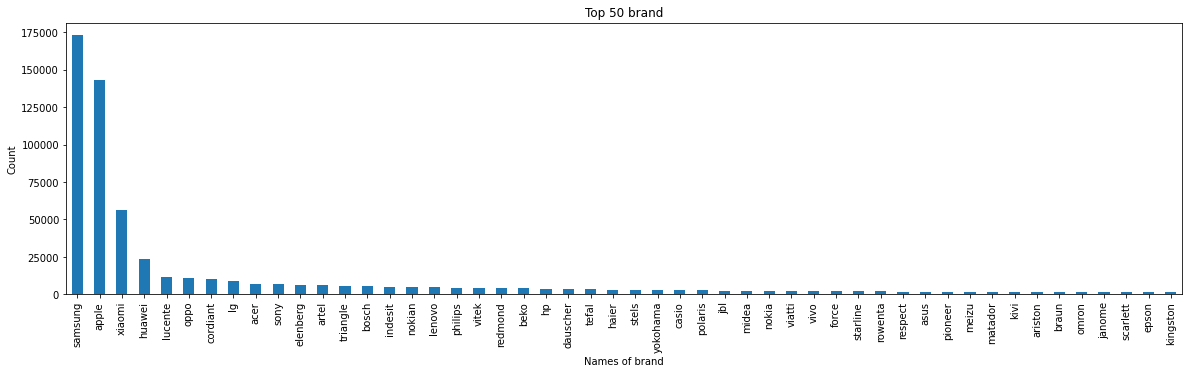

In [ ]:
purchase['brand'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Top 50 brand')
plt.xlabel('Names of brand')
plt.ylabel('Count')
plt.show();

In [ ]:
view = df.loc[df['event_type'] == 'view']

In [ ]:
view = view.reset_index(drop=True)
view

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d
...,...,...,...,...,...,...,...,...,...
37049137,2019-10-31 23:59:58,view,2300275,2053013560530830019,electronics.camera.video,gopro,527.40,537931532,22c57267-da98-4f28-9a9c-18bb5b385193
37049138,2019-10-31 23:59:58,view,10800172,2053013554994348409,NaN,redmond,61.75,527322328,5054190a-46cb-4211-a8f1-16fc1a060ed8
37049139,2019-10-31 23:59:58,view,5701038,2053013553970938175,auto.accessories.player,kenwood,128.70,566280422,05b6c62b-992f-4e8e-91f7-961bcb4719cd
37049140,2019-10-31 23:59:59,view,21407424,2053013561579406073,electronics.clocks,tissot,689.85,513118352,4c14bf2a-2820-4504-929d-046356a5a204


In [ ]:
view_brand = view.groupby('brand')['brand'].agg(['count']).sort_values('count', ascending=False)
view_brand.head(10)

,count
brand,
samsung,4806630
apple,3770597
xiaomi,2922650
huawei,1045572
lucente,644283
bosch,544230
lg,540131
oppo,451449
sony,439855


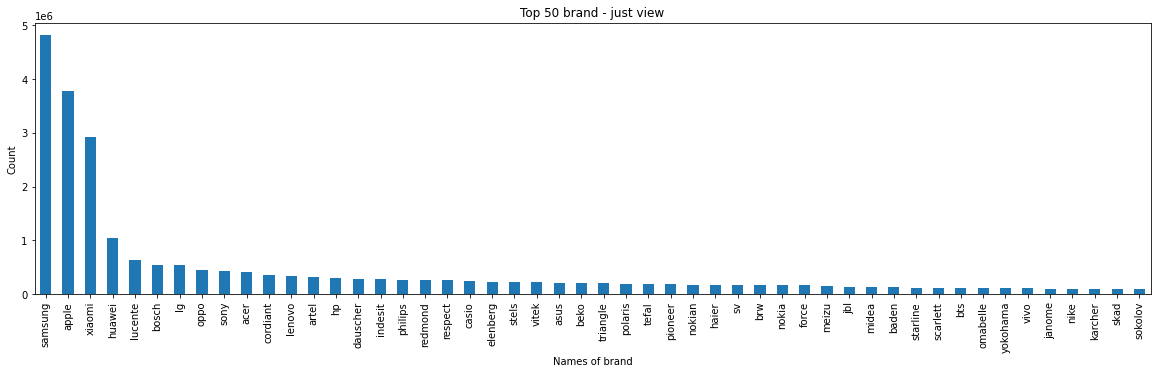

In [ ]:
view['brand'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Top 50 brand - just view')
plt.xlabel('Names of brand')
plt.ylabel('Count')
plt.show();

### 카테고리 별

In [ ]:
purchase['category_code'].value_counts()

electronics.smartphone          338018
electronics.audio.headphone      30503
electronics.video.tv             21565
electronics.clocks               17906
appliances.kitchen.washer        16148
                                 ...  
apparel.skirt                        4
apparel.shorts                       2
apparel.jumper                       2
apparel.jacket                       1
construction.tools.soldering         1
Name: category_code, Length: 121, dtype: int64

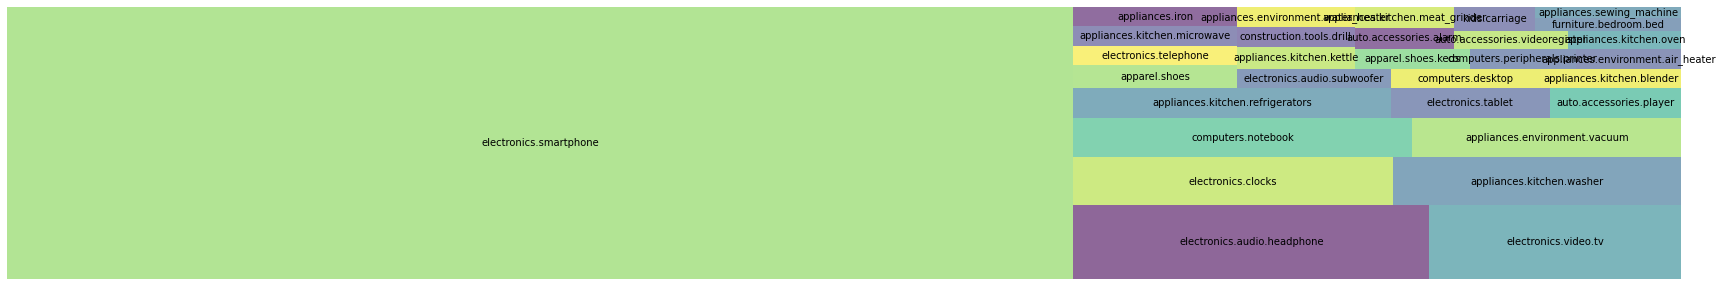

In [ ]:
top_30 = purchase.loc[:,'category_code'].value_counts()[:30].sort_values(ascending=False)
plt.figure(figsize=(30,5))
squarify.plot(top_30, label=top_30.index.array, alpha=0.6)
plt.axis('off')
plt.show();

- 카테고리 코드의 맨 첫번째가 종류, 마지막이 제품
- 나눠서 열 만들수 없을까?

### 카테고리 feature engineering

In [ ]:
purchase['main_category'] = purchase.category_code.str.split('.').str[0]
purchase['subcategory'] = purchase.category_code.str.split('.').str[-1]
purchase = purchase.reset_index(drop=True)

In [ ]:
purchase

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,main_category,subcategory
0,2019-10-01 00:02:14,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564,electronics,smartphone
1,2019-10-01 00:04:37,purchase,1002532,2053013555631882655,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,electronics,smartphone
2,2019-10-01 00:06:02,purchase,5100816,2053013553375346967,NaN,xiaomi,29.51,514591159,0e5dfc4b-2a55-43e6-8c05-97e1f07fbb56,NaN,NaN
3,2019-10-01 00:07:07,purchase,13800054,2053013557418656265,furniture.bathroom.toilet,santeri,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f,furniture,toilet
4,2019-10-01 00:09:26,purchase,4804055,2053013554658804075,electronics.audio.headphone,apple,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553,electronics,headphone
...,...,...,...,...,...,...,...,...,...,...,...
704456,2019-10-31 23:53:53,purchase,1004767,2053013555631882655,electronics.smartphone,samsung,242.63,542774966,957dc70c-31d3-42b7-aef0-2d2827c35251,electronics,smartphone
704457,2019-10-31 23:55:21,purchase,47500017,2110937143172923797,construction.tools.light,puckator,20.59,514622109,5724116e-365b-4ac1-9d03-b8d66e1ccc7c,construction,light
704458,2019-10-31 23:56:03,purchase,1003306,2053013555631882655,electronics.smartphone,apple,577.89,512717356,f35ac37c-9573-4e30-b3d9-c09bb0b95a2b,electronics,smartphone
704459,2019-10-31 23:56:53,purchase,1004240,2053013555631882655,electronics.smartphone,apple,1054.60,533892594,3a5a3b01-2ab1-4a1d-a202-30d336e0057b,electronics,smartphone


In [ ]:
view['main_category'] = view.category_code.str.split('.').str[0]
view['subcategory'] = view.category_code.str.split('.').str[-1]
view = view.reset_index(drop=True)

In [ ]:
view

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,main_category,subcategory
0,2019-10-01 00:00:00,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c,NaN,NaN
1,2019-10-01 00:00:00,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,appliances,water_heater
2,2019-10-01 00:00:01,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8,furniture,sofa
3,2019-10-01 00:00:01,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,computers,notebook
4,2019-10-01 00:00:04,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,electronics,smartphone
...,...,...,...,...,...,...,...,...,...,...,...
37049137,2019-10-31 23:59:58,view,2300275,2053013560530830019,electronics.camera.video,gopro,527.40,537931532,22c57267-da98-4f28-9a9c-18bb5b385193,electronics,video
37049138,2019-10-31 23:59:58,view,10800172,2053013554994348409,NaN,redmond,61.75,527322328,5054190a-46cb-4211-a8f1-16fc1a060ed8,NaN,NaN
37049139,2019-10-31 23:59:58,view,5701038,2053013553970938175,auto.accessories.player,kenwood,128.70,566280422,05b6c62b-992f-4e8e-91f7-961bcb4719cd,auto,player
37049140,2019-10-31 23:59:59,view,21407424,2053013561579406073,electronics.clocks,tissot,689.85,513118352,4c14bf2a-2820-4504-929d-046356a5a204,electronics,clocks


In [ ]:
purchase['main_category'].value_counts()

electronics     423028
appliances       74996
computers        27855
auto             10620
furniture         8301
apparel           8002
construction      7801
kids              5482
accessories       1587
sport             1236
medicine           310
stationery         134
country_yard        72
Name: main_category, dtype: int64

In [ ]:
purchase['subcategory'].value_counts()

smartphone    338018
headphone      30503
tv             21565
clocks         17906
washer         16148
               ...  
skirt              4
shorts             2
jumper             2
jacket             1
soldering          1
Name: subcategory, Length: 119, dtype: int64

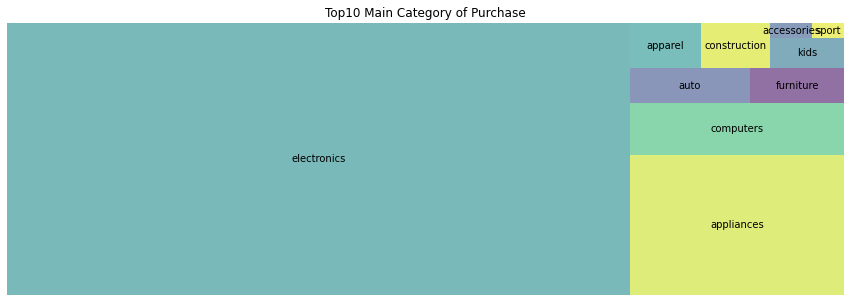

In [ ]:
top_10_main = purchase.loc[:,'main_category'].value_counts()[:10].sort_values(ascending=False)
plt.figure(figsize=(15,5))
squarify.plot(top_10_main, label=top_10_main.index.array, alpha=0.6)
plt.axis('off')
plt.title('Top10 Main Category of Purchase')
plt.show();

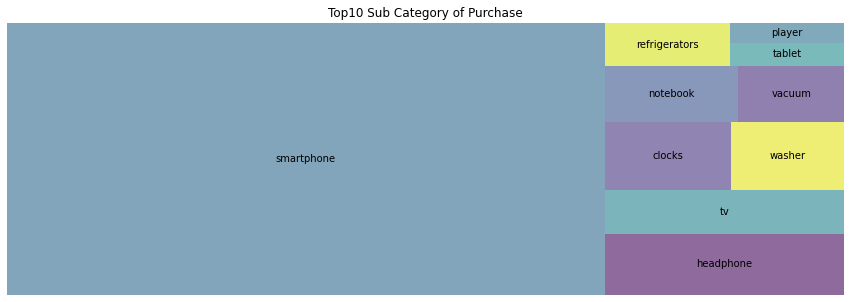

In [ ]:
top_10_sub = purchase.loc[:,'subcategory'].value_counts()[:10].sort_values(ascending=False)
plt.figure(figsize=(15,5))
squarify.plot(sizes=top_10_sub, label=top_10_sub.index.array, alpha=0.6)
plt.axis('off')
plt.title('Top10 Sub Category of Purchase')
plt.show();

In [ ]:
# electronics 에서 sub 순위
electronics = purchase.loc[purchase['main_category'] == 'electronics']
electronics['subcategory'].value_counts()

smartphone    338018
headphone      30503
tv             21565
clocks         17906
tablet          5603
telephone       3738
subwoofer       3348
acoustic         888
microphone       430
piano            423
video            350
photo            174
projector         82
Name: subcategory, dtype: int64

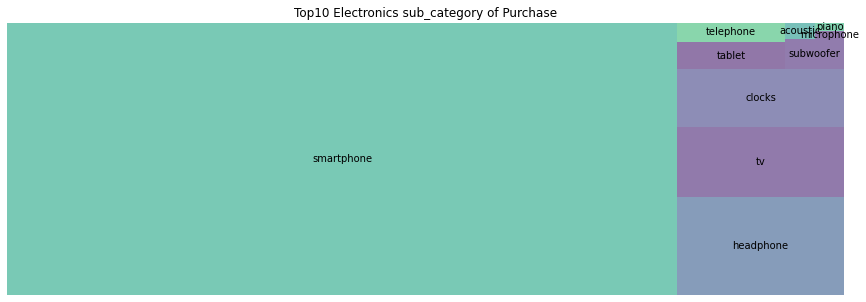

In [ ]:
top_10_elec = electronics.loc[:,'subcategory'].value_counts()[:10].sort_values(ascending=False)
plt.figure(figsize=(15,5))
squarify.plot(sizes=top_10_elec, label=top_10_elec.index.array, alpha=0.6)
plt.axis('off')
plt.title('Top10 Electronics sub_category of Purchase')
plt.show();

In [ ]:
# electronics 를 제외한 카테고리의 순위
non_electronics = purchase.loc[~(purchase['main_category'] == 'electronics')]
non_electronics['subcategory'].value_counts()

washer           16148
notebook         15590
vacuum           12378
refrigerators    11218
player            4647
                 ...  
skirt                4
shorts               2
jumper               2
jacket               1
soldering            1
Name: subcategory, Length: 106, dtype: int64

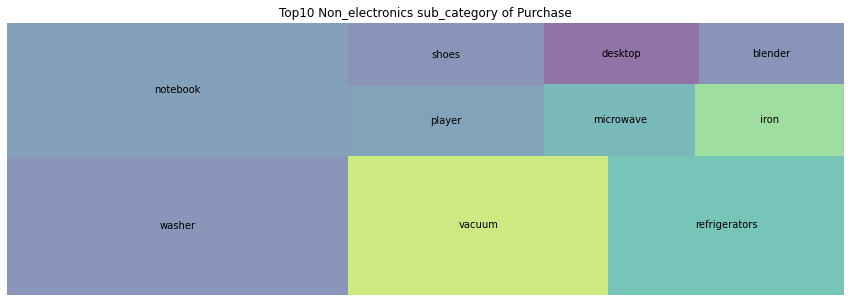

In [ ]:
top_10_nonelec = non_electronics.loc[:,'subcategory'].value_counts()[:10].sort_values(ascending=False)
plt.figure(figsize=(15,5))
squarify.plot(sizes=top_10_nonelec, label=top_10_nonelec.index.array, alpha=0.6)
plt.axis('off')
plt.title('Top10 Non_electronics sub_category of Purchase')
plt.show();

In [ ]:
# electronics, appliances 를 제외한 카테고리의 순위
non_elec_appl = purchase.loc[(~(purchase['main_category'] == 'electronics')) & (~(purchase['main_category'] == 'appliances'))]
non_elec_appl['subcategory'].value_counts()

notebook     15590
player        4647
shoes         4255
desktop       3232
drill         2790
             ...  
skirt            4
shorts           2
jumper           2
jacket           1
soldering        1
Name: subcategory, Length: 78, dtype: int64

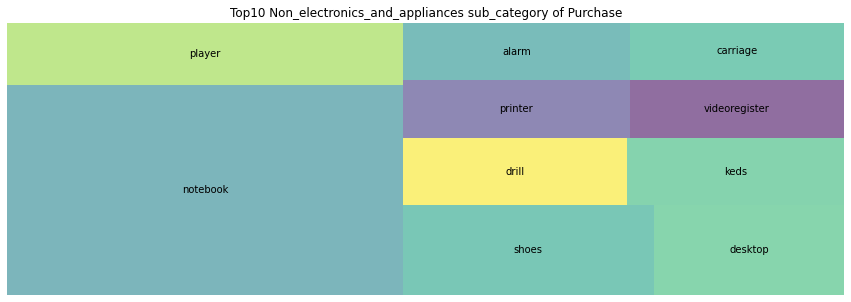

In [ ]:
top_10_non_elec_appl = non_elec_appl.loc[:,'subcategory'].value_counts()[:10].sort_values(ascending=False)
plt.figure(figsize=(15,5))
squarify.plot(sizes=top_10_non_elec_appl, label=top_10_non_elec_appl.index.array, alpha=0.6)
plt.axis('off')
plt.title('Top10 Non_electronics_and_appliances sub_category of Purchase')
plt.show();

In [ ]:
purchase['product_id'].nunique() # 상품 개수

35157

### event 비율

In [ ]:
df['event_type'].value_counts()

view        37049142
cart          918987
purchase      704461
Name: event_type, dtype: int64

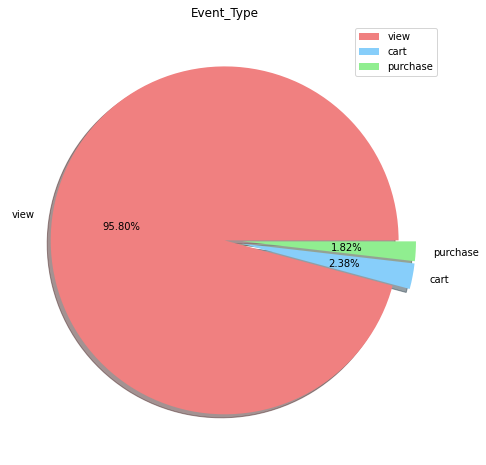

In [ ]:
labels = ['view','cart','purchase']
size = df['event_type'].value_counts()
plt.pie(size, colors = ['lightcoral', 'lightskyblue', 'lightgreen'], explode=[0,0.1,0.1], labels=labels, shadow=True, autopct='%.2f%%')
plt.title('Event_Type')
plt.axis('off')
plt.legend()
plt.show()

### 가격별 구매량

In [ ]:
purchase['price'].describe()

count    704461.000000
mean        318.798049
std         353.588806
min           0.880000
25%          90.170000
50%         185.820000
75%         385.850000
max        2574.070000
Name: price, dtype: float64

In [ ]:
purchase.shape

(704461, 11)

In [ ]:
# 가격 분포를 봤을때 구매한 상품의 평균가격이 전자기기 등 높은 가격대가 많아 평균 또한 높게 나타나는 것으로 보임
high_price = purchase.loc[purchase['price'] > 318]
high_price['main_category'].value_counts()

electronics     169446
appliances       13451
computers        12751
furniture         1659
kids               727
construction       446
auto               322
sport              258
country_yard        18
apparel              2
accessories          2
Name: main_category, dtype: int64

In [ ]:
# 50% 보다 낮은 금액의 상품
low_price = purchase.loc[purchase['price'] < 185]
low_price['main_category'].value_counts()

electronics     149450
appliances       46931
auto              9439
computers         8572
apparel           7897
construction      6705
furniture         5229
kids              4459
accessories       1565
sport              598
medicine           310
stationery         134
country_yard        38
Name: main_category, dtype: int64

In [ ]:
purchase.loc[purchase['price'] >= 318]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,main_category,subcategory
1,2019-10-01 00:04:37,purchase,1002532,2053013555631882655,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,electronics,smartphone
6,2019-10-01 00:10:08,purchase,1002524,2053013555631882655,electronics.smartphone,apple,515.67,524325294,0b74a829-f9d7-4654-b5b0-35bc9822c238,electronics,smartphone
9,2019-10-01 00:14:14,purchase,1004932,2053013555631882655,electronics.smartphone,vivo,463.31,555083442,83d12d1a-5452-4fa0-abbb-d9f492f8b562,electronics,smartphone
10,2019-10-01 02:19:10,purchase,1004246,2053013555631882655,electronics.smartphone,apple,736.18,515246296,b7dbae4f-cad3-463e-89ce-41990cf48dea,electronics,smartphone
11,2019-10-01 02:19:12,purchase,13103842,2053013553526341921,NaN,pdw,391.26,516178643,4d74b49e-3838-43cc-ac2e-a0490942b464,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
704451,2019-10-31 23:49:19,purchase,1004873,2053013555631882655,electronics.smartphone,samsung,362.29,551781196,4b3bb1cc-382f-4909-87fa-81fc9935456c,electronics,smartphone
704453,2019-10-31 23:49:30,purchase,1003316,2053013555631882655,electronics.smartphone,apple,928.38,544501248,8ae7872b-55c5-4e61-ab65-803091bacd7c,electronics,smartphone
704454,2019-10-31 23:49:32,purchase,1002524,2053013555631882655,electronics.smartphone,apple,531.26,516662286,d1b46fb7-cf95-4b40-9460-f7abde16c4d3,electronics,smartphone
704458,2019-10-31 23:56:03,purchase,1003306,2053013555631882655,electronics.smartphone,apple,577.89,512717356,f35ac37c-9573-4e30-b3d9-c09bb0b95a2b,electronics,smartphone


In [ ]:
(214542 / 704461) *100 # 전체 구매자 중 평균가격보다 높은 금액대의 상품을 구매한 비율

30.45477322378386

In [ ]:
purchase.loc[purchase['price'] < 318]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,main_category,subcategory
0,2019-10-01 00:02:14,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564,electronics,smartphone
2,2019-10-01 00:06:02,purchase,5100816,2053013553375346967,NaN,xiaomi,29.51,514591159,0e5dfc4b-2a55-43e6-8c05-97e1f07fbb56,NaN,NaN
3,2019-10-01 00:07:07,purchase,13800054,2053013557418656265,furniture.bathroom.toilet,santeri,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f,furniture,toilet
4,2019-10-01 00:09:26,purchase,4804055,2053013554658804075,electronics.audio.headphone,apple,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553,electronics,headphone
5,2019-10-01 00:09:54,purchase,4804056,2053013554658804075,electronics.audio.headphone,apple,161.98,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,electronics,headphone
...,...,...,...,...,...,...,...,...,...,...,...
704452,2019-10-31 23:49:26,purchase,5100816,2053013553375346967,NaN,xiaomi,29.58,514905226,6f25d2de-bb1c-4e68-b848-f03372fb6e7d,NaN,NaN
704455,2019-10-31 23:50:16,purchase,1004767,2053013555631882655,electronics.smartphone,samsung,242.63,551781196,4b3bb1cc-382f-4909-87fa-81fc9935456c,electronics,smartphone
704456,2019-10-31 23:53:53,purchase,1004767,2053013555631882655,electronics.smartphone,samsung,242.63,542774966,957dc70c-31d3-42b7-aef0-2d2827c35251,electronics,smartphone
704457,2019-10-31 23:55:21,purchase,47500017,2110937143172923797,construction.tools.light,puckator,20.59,514622109,5724116e-365b-4ac1-9d03-b8d66e1ccc7c,construction,light


In [ ]:
(489919 / 704461) *100

69.54522677621614

In [ ]:
under_med = purchase.loc[purchase['price'] < 185]

In [ ]:
(350725 / 704461) *100 # 전체 구매자 중 중앙값보다 낮은 금액대의 상품을 구매한 비율

49.78629051146905

In [ ]:
# 중앙값보다 낮은 상품의 종류
under_med['main_category'].value_counts()

electronics     149450
appliances       46931
auto              9439
computers         8572
apparel           7897
construction      6705
furniture         5229
kids              4459
accessories       1565
sport              598
medicine           310
stationery         134
country_yard        38
Name: main_category, dtype: int64

In [ ]:
under_med.loc[under_med['main_category'] == "electronics"]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,main_category,subcategory
0,2019-10-01 00:02:14,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564,electronics,smartphone
5,2019-10-01 00:09:54,purchase,4804056,2053013554658804075,electronics.audio.headphone,apple,161.98,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,electronics,headphone
8,2019-10-01 00:12:14,purchase,4802036,2053013554658804075,electronics.audio.headphone,apple,171.56,533624186,e5ac3caa-e6d5-4d6b-ae06-2c18cd9ca683,electronics,headphone
15,2019-10-01 02:20:20,purchase,4804295,2053013554658804075,electronics.audio.headphone,xiaomi,23.13,540557704,0c990471-9407-4292-a6df-0cbc2f722a40,electronics,headphone
20,2019-10-01 02:21:59,purchase,4804501,2053013554658804075,electronics.audio.headphone,ritmix,3.37,514127317,b332ec72-5344-49e5-a3d5-27507b726259,electronics,headphone
...,...,...,...,...,...,...,...,...,...,...,...
704421,2019-10-31 23:35:11,purchase,1004863,2053013555631882655,electronics.smartphone,samsung,170.14,559242302,371c4d85-d114-4da4-9f17-d902ea47f7ca,electronics,smartphone
704423,2019-10-31 23:36:41,purchase,1004863,2053013555631882655,electronics.smartphone,samsung,170.14,559242302,371c4d85-d114-4da4-9f17-d902ea47f7ca,electronics,smartphone
704429,2019-10-31 23:40:19,purchase,4802955,2053013554658804075,electronics.audio.headphone,hyperx,107.85,519366802,52329a85-fe91-4635-842b-66d3e819b92a,electronics,headphone
704439,2019-10-31 23:44:02,purchase,4804295,2053013554658804075,electronics.audio.headphone,xiaomi,22.80,519366802,467f84d6-fe36-48ba-a916-caa20125812f,electronics,headphone


In [ ]:
under_med['subcategory'].value_counts()

smartphone    100375
headphone      26502
vacuum          9759
clocks          7458
shoes           4215
               ...  
cultivator         2
shorts             2
jumper             2
jacket             1
soldering          1
Name: subcategory, Length: 115, dtype: int64

In [ ]:
elec = purchase.loc[purchase['main_category'] == "electronics"]

In [ ]:
elec['price'].mean()

417.1453623873433

In [ ]:
elec.loc[elec['subcategory'] == "headphone"]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,main_category,subcategory
4,2019-10-01 00:09:26,purchase,4804055,2053013554658804075,electronics.audio.headphone,apple,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553,electronics,headphone
5,2019-10-01 00:09:54,purchase,4804056,2053013554658804075,electronics.audio.headphone,apple,161.98,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,electronics,headphone
8,2019-10-01 00:12:14,purchase,4802036,2053013554658804075,electronics.audio.headphone,apple,171.56,533624186,e5ac3caa-e6d5-4d6b-ae06-2c18cd9ca683,electronics,headphone
13,2019-10-01 02:20:11,purchase,4804055,2053013554658804075,electronics.audio.headphone,apple,189.91,517129864,df8afa49-66e0-4e54-b9ca-4be6de5c9a0f,electronics,headphone
15,2019-10-01 02:20:20,purchase,4804295,2053013554658804075,electronics.audio.headphone,xiaomi,23.13,540557704,0c990471-9407-4292-a6df-0cbc2f722a40,electronics,headphone
...,...,...,...,...,...,...,...,...,...,...,...
704400,2019-10-31 23:21:05,purchase,4803894,2053013554658804075,electronics.audio.headphone,jbl,48.14,566092490,763b3e3f-a5c7-4f90-8f39-ada3220304ff,electronics,headphone
704419,2019-10-31 23:33:11,purchase,4804056,2053013554658804075,electronics.audio.headphone,apple,160.57,526208213,d175757c-15ef-40a8-a0aa-03d3ee90e065,electronics,headphone
704429,2019-10-31 23:40:19,purchase,4802955,2053013554658804075,electronics.audio.headphone,hyperx,107.85,519366802,52329a85-fe91-4635-842b-66d3e819b92a,electronics,headphone
704439,2019-10-31 23:44:02,purchase,4804295,2053013554658804075,electronics.audio.headphone,xiaomi,22.80,519366802,467f84d6-fe36-48ba-a916-caa20125812f,electronics,headphone


In [ ]:
(30503 / 149450) * 100

20.4101706256273

In [ ]:
non_headphone = elec.loc[~(elec['subcategory'] == "headphone")]

In [ ]:
non_headphone['subcategory'].value_counts()

smartphone    338018
tv             21565
clocks         17906
tablet          5603
telephone       3738
subwoofer       3348
acoustic         888
microphone       430
piano            423
video            350
photo            174
projector         82
Name: subcategory, dtype: int64

### RFM 지수
- 가치있는 고객을 추출해내어 이를 기준으로 고객을 분류할 수 있는 지수
- segment
   - segment1 : 누적 구매횟수와 누적 구매금액이 많으면서 최근 구매이력이 있는 고객 → VVIP
   - segment2 : 누적 구매횟수는 많지만 누적 구매금액이 적고 최근 구매이력이 있는 고객 → VIP or VVIP 로 끌어 올려야하는 타겟 고객
   - segment3 : 누적 구매횟수와 구매 금액이 많지만 최근 구매이력은 없는 고객 → 변심 고객이 되돌아올 수 있도록 즉각적이고 긴급한 마케팅 대응 필요
   - segment4 : 누적 구매횟수는 적으나 최근 구매이력이 있는 고객 → 향후 VIP, VVIP로 끌어올려야 하는 타겟 고객
   - segment5 : 일정 이상 마케팅 시나리오에 반응하지 않는다면 제거 대상인 체리피커

In [ ]:
purchase

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:02:14,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564
1,2019-10-01 00:04:37,purchase,1002532,2053013555631882655,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68
2,2019-10-01 00:06:02,purchase,5100816,2053013553375346967,NaN,xiaomi,29.51,514591159,0e5dfc4b-2a55-43e6-8c05-97e1f07fbb56
3,2019-10-01 00:07:07,purchase,13800054,2053013557418656265,furniture.bathroom.toilet,santeri,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f
4,2019-10-01 00:09:26,purchase,4804055,2053013554658804075,electronics.audio.headphone,apple,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553
...,...,...,...,...,...,...,...,...,...
704456,2019-10-31 23:53:53,purchase,1004767,2053013555631882655,electronics.smartphone,samsung,242.63,542774966,957dc70c-31d3-42b7-aef0-2d2827c35251
704457,2019-10-31 23:55:21,purchase,47500017,2110937143172923797,construction.tools.light,puckator,20.59,514622109,5724116e-365b-4ac1-9d03-b8d66e1ccc7c
704458,2019-10-31 23:56:03,purchase,1003306,2053013555631882655,electronics.smartphone,apple,577.89,512717356,f35ac37c-9573-4e30-b3d9-c09bb0b95a2b
704459,2019-10-31 23:56:53,purchase,1004240,2053013555631882655,electronics.smartphone,apple,1054.60,533892594,3a5a3b01-2ab1-4a1d-a202-30d336e0057b


In [ ]:
merge_session = purchase.groupby(by = 'user_session').agg(Date_order = ('event_time', lambda x: x.max()),
                                                          user_id = ('user_id', lambda x: x.unique()),
                                                          Quantity = ('user_session', 'count'),
                                                          money_spent = ('price', 'sum')).reset_index(drop=True)

In [ ]:
# 날짜마다 몇개 세션인지, 얼마 지불했는지
merge_session.head()

,Date_order,user_id,Quantity,money_spent
0,2019-10-06 11:34:30,546521725,1,289.52
1,2019-10-25 08:39:11,560486342,1,171.90
2,2019-10-17 13:37:59,560744406,2,379.78
3,2019-10-15 08:09:02,520649833,1,90.07
4,2019-10-23 14:27:08,534210306,2,571.92


In [ ]:
merge_session.dtypes

Date_order      object
user_id          int64
Quantity         int64
money_spent    float64
dtype: object

In [ ]:
import datetime
merge_session['Date_order'] = pd.to_datetime(merge_session['Date_order'])

In [ ]:
# 2019.11.1 기준 얼마나 최근에 구매했는지
import datetime as dt
import numpy as np
date = dt.datetime(2019,11,1)
merge_session['last_purchase'] = date - merge_session['Date_order']
merge_session['last_purchase'].astype('timedelta64[D]')
merge_session['last_purchase'] = merge_session['last_purchase'] / np.timedelta64(1, 'D')

In [ ]:
merge_session.head()

,Date_order,user_id,Quantity,money_spent,last_purchase
0,2019-10-06 11:34:30,546521725,1,289.52,25.517708
1,2019-10-25 08:39:11,560486342,1,171.90,6.639456
2,2019-10-17 13:37:59,560744406,2,379.78,14.431956
3,2019-10-15 08:09:02,520649833,1,90.07,16.660394
4,2019-10-23 14:27:08,534210306,2,571.92,8.397824


In [ ]:
# RFM 지수
user_pattern = merge_session.groupby('user_id').agg(Recency = ('last_purchase', lambda x: x.min()),
                                               Frequency = ('user_id', lambda x: x.count()),
                                               Monetary = ('money_spent', lambda x: x.sum()))

In [ ]:
purchase['user_id'].nunique()

333701

In [ ]:
user_pattern.sort_values(by='Monetary')

,Recency,Frequency,Monetary
user_id,,,
563893002,6.849687,1,0.88
566252844,0.130984,1,0.88
535243241,2.606574,1,0.88
534066409,6.675023,1,0.88
513085966,23.426921,1,0.88
...,...,...,...
512386086,0.587523,152,182470.80
530834332,0.778970,65,187128.93
515384420,0.324502,64,210749.77


In [ ]:
user_pattern['Recency'].describe()

count    333701.000000
mean         14.183346
std           8.673088
min           0.000509
25%           6.666169
50%          13.693900
75%          21.095602
max          30.995810
Name: Recency, dtype: float64

In [ ]:
user_pattern['Frequency'].describe()

count    333701.000000
mean          1.795820
std           2.404126
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         152.000000
Name: Frequency, dtype: float64

In [ ]:
user_pattern['Monetary'].describe()

count    333701.000000
mean        673.000058
std        2101.621661
min           0.880000
25%         111.820000
50%         249.860000
75%         613.920000
max      265569.520000
Name: Monetary, dtype: float64

In [ ]:
# 2번 이상 구매한 고객
more_twice = user_pattern.loc[user_pattern['Frequency'] >= 2]

In [ ]:
more_twice.shape

(105726, 9)

In [ ]:
(105726 / 333701) * 100 # 2번 이상 구매한 고객 비율

31.682853812245092

### segment

In [ ]:
user_pattern.quantile(q=[0.25,0.5,0.75])

,Recency,Frequency,Monetary
0.25,6.666169,1.0,111.82
0.50,13.693900,1.0,249.86
0.75,21.095602,2.0,613.92


In [ ]:
quantile = user_pattern.quantile(q=[0.25,0.5,0.75]).to_dict()
quantile

{'Frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 2.0},
 'Monetary': {0.25: 111.82, 0.5: 249.86, 0.75: 613.92},
 'Recency': {0.25: 6.666168981481482,
  0.5: 13.693900462962963,
  0.75: 21.095601851851853}}

In [ ]:
# recency - 점수 낮을수록 좋음
def Recency(x, p, d):
  if x <= d[p][0.25]:
    return 1
  elif x <= d[p][0.50]:
    return 2
  elif x <= d[p][0.75]:
    return 3
  else:
    return 4

# frequency, monetary - 점수 낮을수록 좋음
def FM(x, p, d):
  if x <= d[p][0.25]:
    return 4
  elif x <= d[p][0.50]:
    return 3
  elif x <= d[p][0.75]:
    return 2
  else:
    return 1

In [ ]:
user_pattern['Recency_score'] = user_pattern['Recency'].apply(Recency, args = ('Recency', quantile,))
user_pattern['Frequency_score'] = user_pattern['Frequency'].apply(FM, args = ('Frequency', quantile,))
user_pattern['Monetary_score'] = user_pattern['Monetary'].apply(FM, args = ('Monetary', quantile,))
user_pattern['RFM_seg'] = user_pattern.Recency_score.map(str) + user_pattern.Frequency_score.map(str) + user_pattern.Monetary_score.map(str)
user_pattern['RFM_score'] = user_pattern.Recency_score.map(int) + user_pattern.Frequency_score.map(int) + user_pattern.Monetary_score.map(int)

In [ ]:
user_pattern.head()

,Recency,Frequency,Monetary,Recency_score,Frequency_score,Monetary_score,RFM_seg,RFM_score
user_id,,,,,,,,
264649825,25.141539,2,1240.04,4,2,1,421,7
303160429,18.440637,1,340.59,3,4,2,342,9
340041246,17.384965,3,915.52,3,1,1,311,5
384989212,13.527789,1,41.44,2,4,4,244,10
396222093,7.253611,1,48.14,2,4,4,244,10


In [ ]:
user_pattern['RFM_score'].value_counts()

9     58520
10    53288
8     44267
11    40717
7     33188
6     26142
12    22245
5     21181
4     18294
3     15859
Name: RFM_score, dtype: int64

In [ ]:
# 3~12점으로 분포되어 있어 5개 구간을 2점씩 나누어 분배
def label(data):
  if data['RFM_score'] >= 11:
    return "segment5"
  elif ((data['RFM_score'] >= 9) & (data['RFM_score'] < 11)):
    return "segment4"
  elif  ((data['RFM_score'] >= 7) & (data['RFM_score'] < 9)):
    return "segment3"
  elif ((data['RFM_score'] >= 5) & (data['RFM_score'] < 7)):
    return "segment2"
  else:
    return "segment1"

In [ ]:
user_pattern['RFM_label'] = user_pattern.apply(label, axis=1)

In [ ]:
user_pattern

,Recency,Frequency,Monetary,Recency_score,Frequency_score,Monetary_score,RFM_seg,RFM_score,RFM_label
user_id,,,,,,,,,
264649825,25.141539,2,1240.04,4,2,1,421,7,segment3
303160429,18.440637,1,340.59,3,4,2,342,9,segment4
340041246,17.384965,3,915.52,3,1,1,311,5,segment2
384989212,13.527789,1,41.44,2,4,4,244,10,segment4
396222093,7.253611,1,48.14,2,4,4,244,10,segment4
...,...,...,...,...,...,...,...,...,...
566270177,0.061609,1,75.94,1,4,4,144,9,segment4
566272569,0.024861,2,254.84,1,2,2,122,5,segment2
566274637,0.037755,1,2011.63,1,4,1,141,6,segment2


In [ ]:
user_pattern.to_csv("RFM.csv")

In [ ]:
RFM = user_pattern.groupby("RFM_label").agg({"Recency": "mean", "Frequency" : "mean", "Monetary" : ["mean","count"]}).round(2)

In [ ]:
RFM

Recency Frequency Monetary        
             mean      mean     mean   count
RFM_label                                   
segment1     4.94      5.55  2886.06   34153
segment2    10.59      2.60  1106.17   47323
segment3    11.10      1.37   495.94   77455
segment4    15.55      1.05   263.72  111808
segment5    23.27      1.00    91.58   62962

In [ ]:
RFM["Monetary"]["count"].sum()

333701

In [ ]:
# segment1
(34153 / 333701)*100

10.234611223820126

In [ ]:
# segment2
(47323 / 333701)*100

14.181258072346203

In [ ]:
# segment3
(77455 / 333701)*100

23.210898379087865

In [ ]:
# segment4
(111808 / 333701)*100

33.5054434958241

In [ ]:
# segment5
(62962 / 333701)*100

18.8677888289217

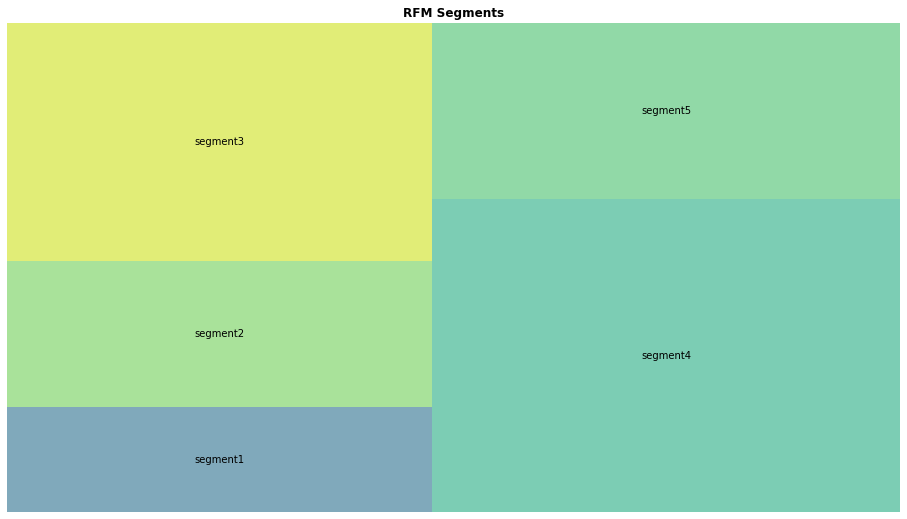

In [ ]:
# RFM.columns = RFM.columns.droplevel()
RFM.columns = ['RecencyMean', 'FrequencyMean','MonetaryMean','Count']
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16,9)
squarify.plot(sizes=RFM['Count'], label=['segment1','segment2','segment3','segment4','segment5'], alpha=.6)
plt.title("RFM Segments", fontweight='bold')
plt.axis("off")
plt.show();

### segment3, segment4에 있는 고객의 주요 상품

In [ ]:
seg3_4 = pd.read_csv("/content/drive/MyDrive/seg3_4.csv")

In [ ]:
seg3_4

,user_id,RFM_label,brand,main_category,subcategory,price
0,264649825,segment3,kiturami,NaN,NaN,552.14
1,264649825,segment3,kiturami,NaN,NaN,687.90
2,303160429,segment4,garmin,electronics,clocks,340.59
3,384989212,segment4,artel,appliances,oven,41.44
4,396222093,segment4,cordiant,NaN,NaN,48.14
...,...,...,...,...,...,...
249022,566267483,segment4,x-game,computers,mouse,5.03
249023,566270060,segment3,hansa,appliances,microwave,59.13
249024,566270060,segment3,samsung,electronics,smartphone,88.29
249025,566270177,segment4,stels,NaN,NaN,75.94


In [ ]:
seg3_4['brand'].value_counts()

samsung     61940
apple       37724
xiaomi      21613
huawei       8978
cordiant     4763
            ...  
indigo          1
weider          1
ferre           1
bot             1
afox            1
Name: brand, Length: 1662, dtype: int64

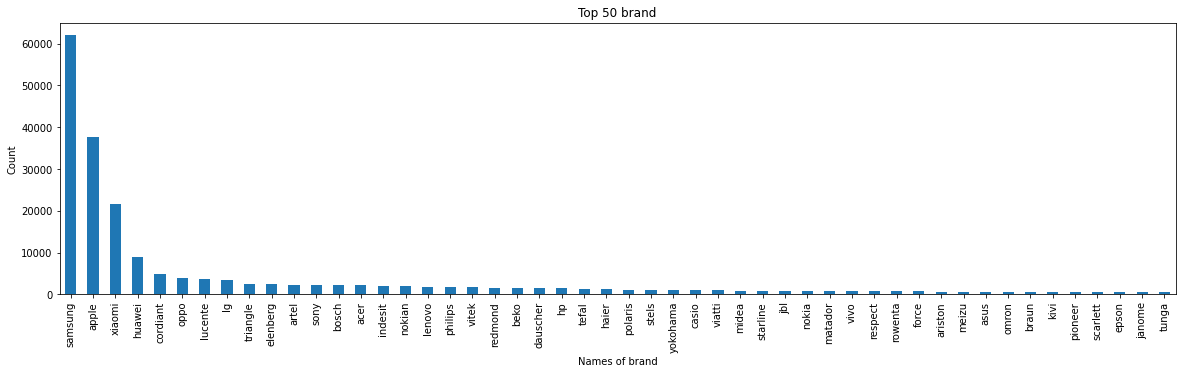

In [ ]:
seg3_4['brand'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Top 50 brand')
plt.xlabel('Names of brand')
plt.ylabel('Count')
plt.show();

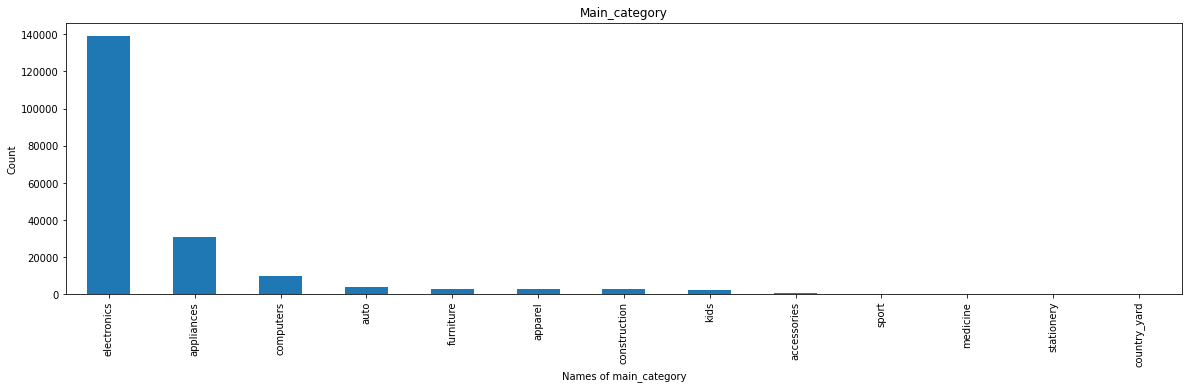

In [ ]:
seg3_4['main_category'].value_counts().plot.bar(figsize=(20,5))
plt.title('Main_category')
plt.xlabel('Names of main_category')
plt.ylabel('Count')
plt.show();

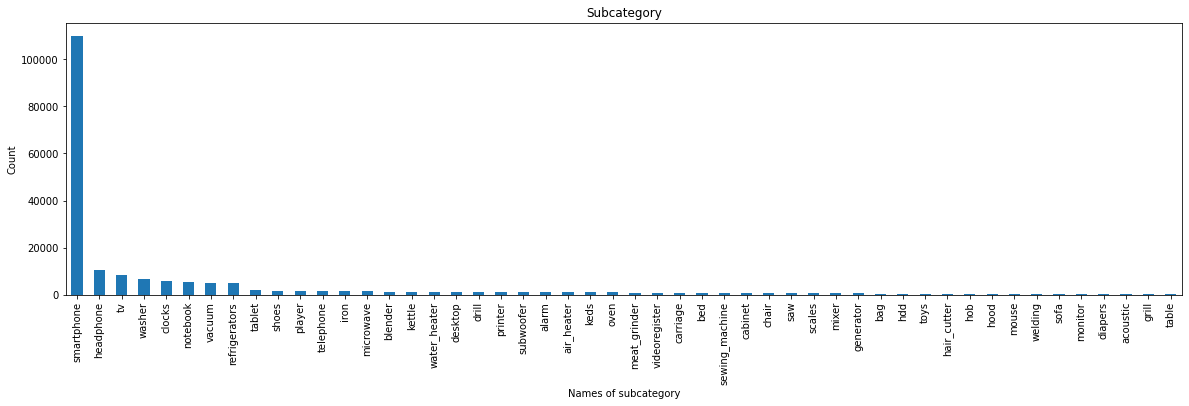

In [ ]:
seg3_4['subcategory'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Subcategory')
plt.xlabel('Names of subcategory')
plt.ylabel('Count')
plt.show();

### 2번 이상 구매한 고객의 인기상품

In [ ]:
more_twice_bought = pd.read_csv("/content/drive/MyDrive/more_twice_bought.csv")

In [ ]:
more_twice_bought

,user_id,product_id,main_category,subcategory,brand,price
0,264649825,8500083,NaN,NaN,kiturami,552.14
1,264649825,8500084,NaN,NaN,kiturami,687.90
2,340041246,2100099,electronics,tv,lg,339.70
3,340041246,9300037,NaN,NaN,lg,174.78
4,340041246,9300037,NaN,NaN,lg,200.52
...,...,...,...,...,...,...
453073,566243643,4804295,electronics,headphone,xiaomi,22.80
453074,566243643,4804295,electronics,headphone,xiaomi,22.80
453075,566243643,28704135,apparel,keds,nike,159.33
453076,566272569,12704161,NaN,NaN,pirelli,131.28


In [ ]:
more_main_category = more_twice_bought['main_category'].value_counts()
more_main_category

electronics     284607
appliances       43060
computers        18502
auto              6470
apparel           5379
furniture         5214
construction      4707
kids              3426
accessories       1107
sport              730
medicine           159
stationery          72
country_yard        35
Name: main_category, dtype: int64

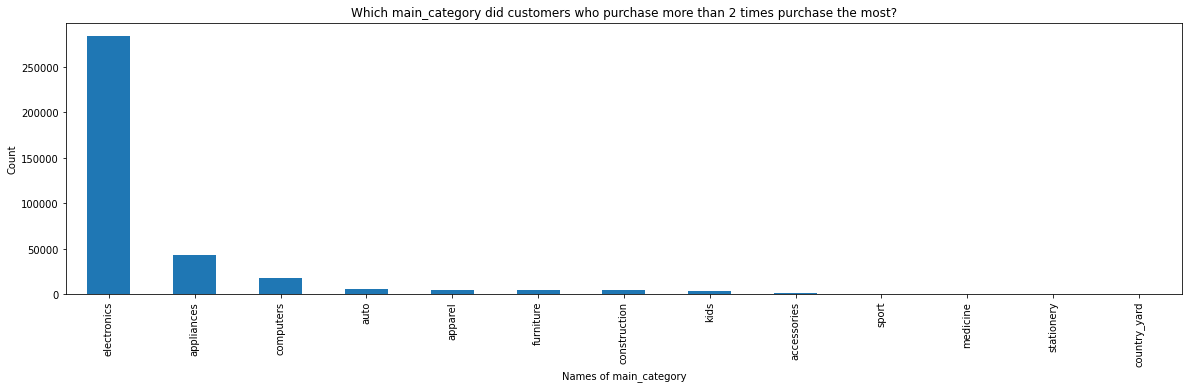

In [ ]:
more_twice_bought['main_category'].value_counts().plot.bar(figsize=(20,5))
plt.title('Which main_category did customers who purchase more than 2 times purchase the most?')
plt.xlabel('Names of main_category')
plt.ylabel('Count')
plt.show();

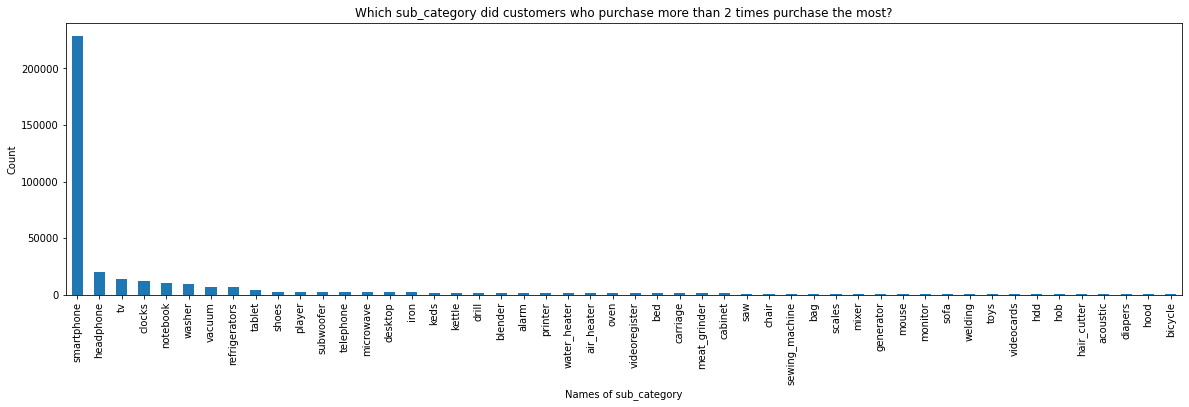

In [ ]:
more_twice_bought['subcategory'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Which sub_category did customers who purchase more than 2 times purchase the most?')
plt.xlabel('Names of sub_category')
plt.ylabel('Count')
plt.show();

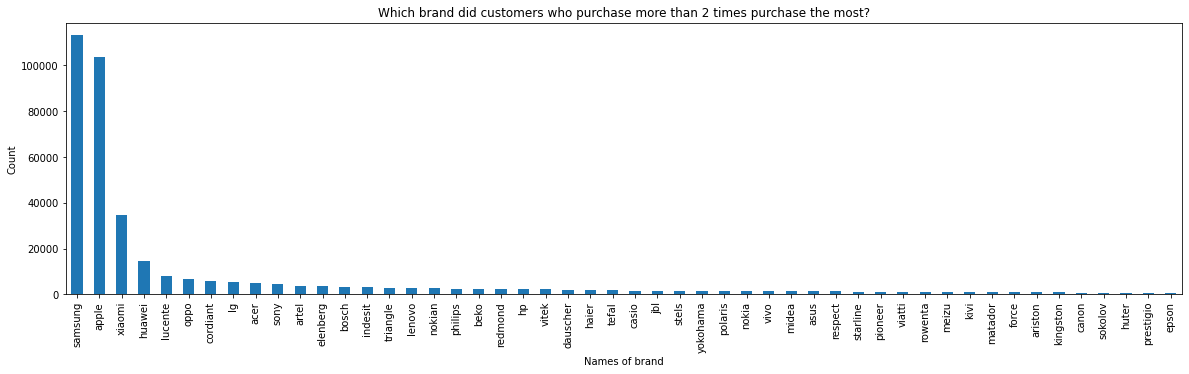

In [ ]:
more_twice_bought['brand'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Which brand did customers who purchase more than 2 times purchase the most?')
plt.xlabel('Names of brand')
plt.ylabel('Count')
plt.show();

### 2번 이상 구매한 고객 중 $100 이하로 지출한 고객이 구매한 상품

In [ ]:
distinct_under100 = pd.read_csv("/content/drive/MyDrive/distinct_under100.csv")

In [ ]:
distinct_under100

,user_id,brand,main_category,subcategory
0,434715713,xiaomi,NaN,NaN
1,482204269,aquamarine,NaN,NaN
2,482204269,sokolov,NaN,NaN
3,501815900,NaN,auto,videoregister
4,501815900,omron,NaN,NaN
...,...,...,...,...
11714,566032106,xiaomi,NaN,NaN
11715,566122364,polaris,appliances,blender
11716,566122364,tefal,appliances,iron
11717,566194657,cordiant,NaN,NaN


In [ ]:
distinct_under100['brand'].value_counts().head(50)

xiaomi       1383
cordiant      766
elenberg      608
vitek         384
triangle      363
             ... 
anytek          1
yacco           1
gigawatt        1
ecocool         1
attribute       1
Name: brand, Length: 738, dtype: int64

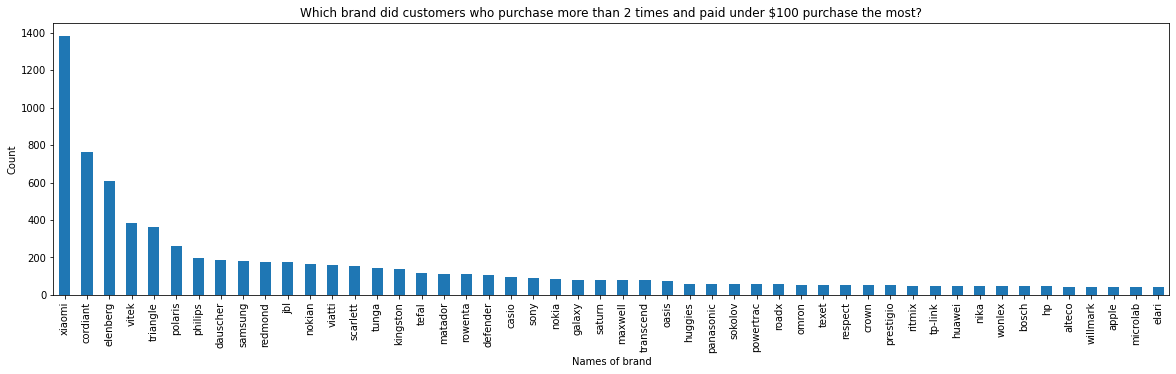

In [ ]:
under100_brand = distinct_under100['brand'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Which brand did customers who purchase more than 2 times and paid under $100 purchase the most?')
plt.xlabel('Names of brand')
plt.ylabel('Count')
plt.show();

In [ ]:
distinct_under100['main_category'].value_counts()

appliances      2139
electronics     1686
computers        446
kids             294
construction     209
apparel          172
auto             158
furniture        142
accessories      125
medicine          26
stationery        20
sport              2
country_yard       1
Name: main_category, dtype: int64

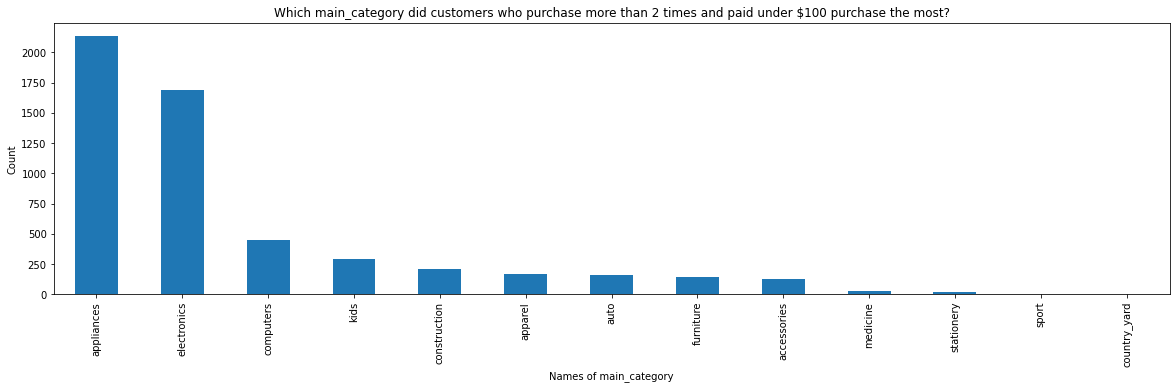

In [ ]:
under100_main = distinct_under100['main_category'].value_counts().plot.bar(figsize=(20,5))
plt.title('Which main_category did customers who purchase more than 2 times and paid under $100 purchase the most?')
plt.xlabel('Names of main_category')
plt.ylabel('Count')
plt.show();

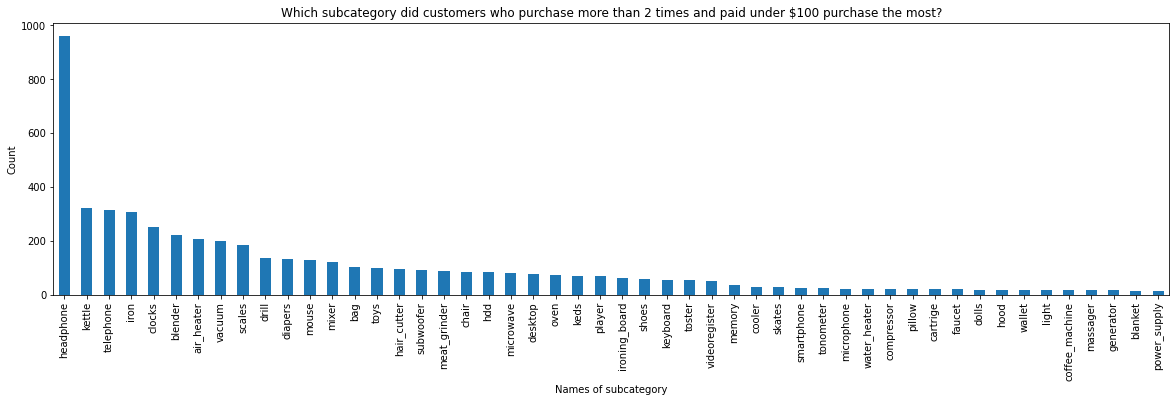

In [ ]:
under100_sub = distinct_under100['subcategory'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Which subcategory did customers who purchase more than 2 times and paid under $100 purchase the most?')
plt.xlabel('Names of subcategory')
plt.ylabel('Count')
plt.show();

### 2번 이상 구매한 고객 중 평균 금액 이하($342)로 지출한 고객이 구매한 상품

In [ ]:
less_avg_twice = pd.read_csv("/content/less_avg_twice.csv")

In [ ]:
less_avg_twice['brand'].value_counts()

samsung     89877
xiaomi      31820
apple       14012
huawei      13923
oppo         5974
            ...  
rokids          1
corpus          1
kyocera         1
wangfeng        1
forza           1
Name: brand, Length: 1655, dtype: int64

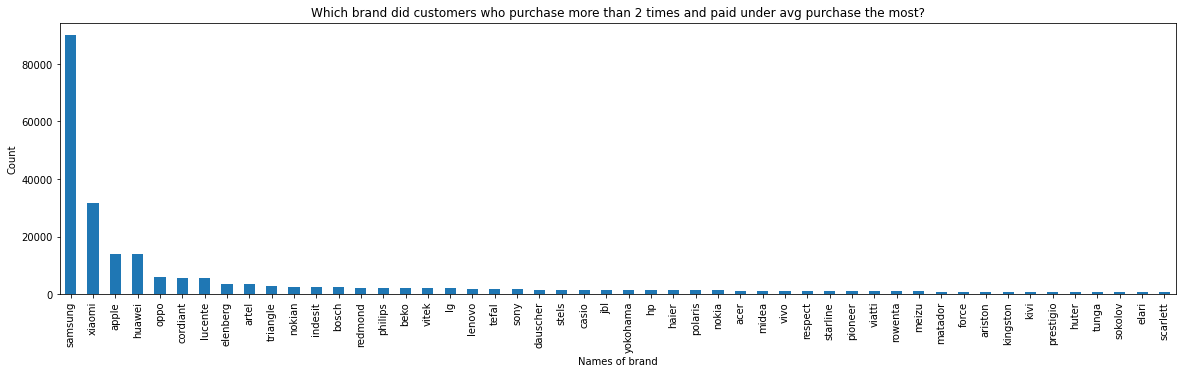

In [ ]:
less_avg_brand = less_avg_twice['brand'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Which brand did customers who purchase more than 2 times and paid under avg purchase the most?')
plt.xlabel('Names of brand')
plt.ylabel('Count')
plt.show();

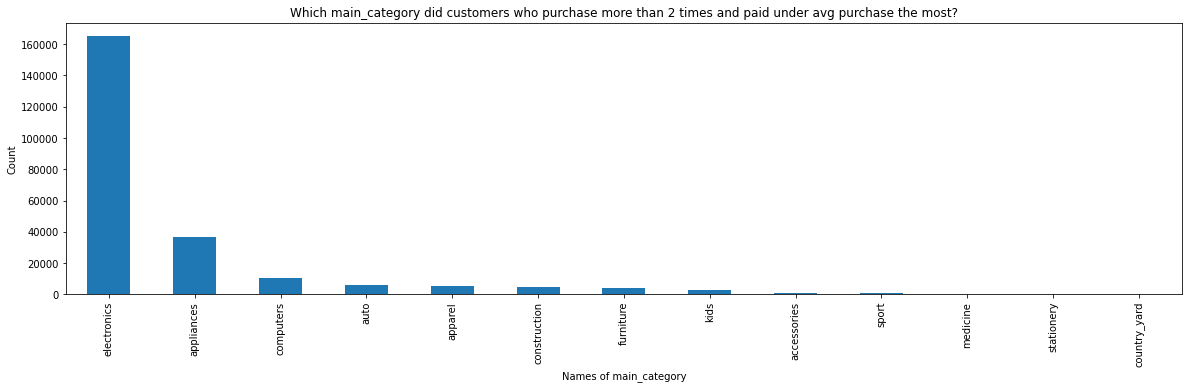

In [ ]:
less_avg_main = less_avg_twice['main_category'].value_counts().plot.bar(figsize=(20,5))
plt.title('Which main_category did customers who purchase more than 2 times and paid under avg purchase the most?')
plt.xlabel('Names of main_category')
plt.ylabel('Count')
plt.show();

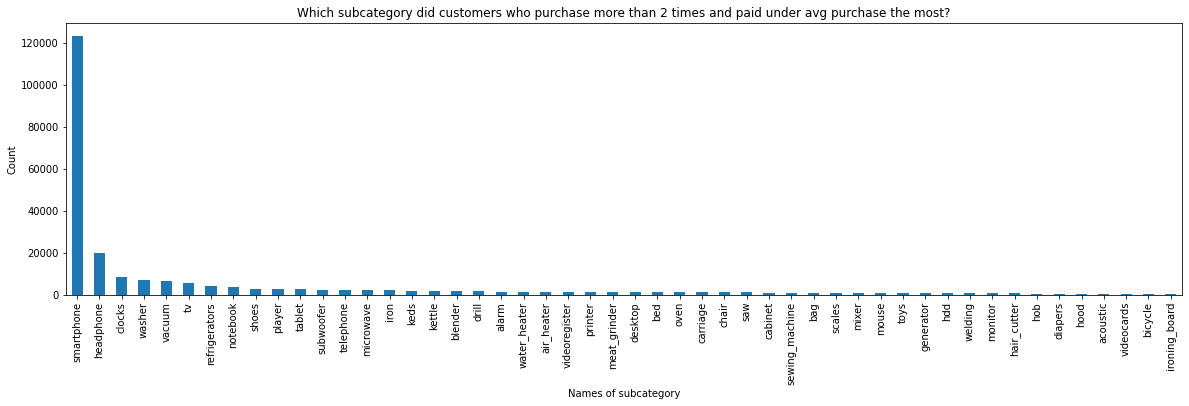

In [ ]:
less_avg_sub = less_avg_twice['subcategory'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Which subcategory did customers who purchase more than 2 times and paid under avg purchase the most?')
plt.xlabel('Names of subcategory')
plt.ylabel('Count')
plt.show();

### 구매하지 않은 고객
- view만하고 한번도 구매하지 않은 고객

In [ ]:
non_purchase = pd.read_csv("/content/drive/MyDrive/non_purchase.csv")

In [ ]:
non_purchase['main_category'] = non_purchase.category_code.str.split('.').str[0]
non_purchase['subcategory'] = non_purchase.category_code.str.split('.').str[-1]
non_purchase = non_purchase.reset_index(drop=True)

In [ ]:
non_purchase

,event_time,product_id,category_code,brand,price,user_id,user_session,main_category,subcategory
0,2019-10-23 20:04:08 UTC,7002639,kids.carriage,bumbleride,769.65,33869381,d83dc524-8a2c-4780-bbe0-f8aee03b54df,kids,carriage
1,2019-10-04 17:44:37 UTC,6902133,furniture.living_room.chair,joie,143.89,184265397,2c5d0468-32e1-42f7-9b4e-b17c1d387247,furniture,chair
2,2019-10-04 17:45:18 UTC,6902133,furniture.living_room.chair,joie,143.89,184265397,2c5d0468-32e1-42f7-9b4e-b17c1d387247,furniture,chair
3,2019-10-04 17:50:50 UTC,6902303,furniture.living_room.chair,joie,111.46,184265397,2c5d0468-32e1-42f7-9b4e-b17c1d387247,furniture,chair
4,2019-10-04 17:51:04 UTC,6902303,furniture.living_room.chair,joie,111.46,184265397,2c5d0468-32e1-42f7-9b4e-b17c1d387247,furniture,chair
...,...,...,...,...,...,...,...,...,...
25768427,2019-10-31 23:58:19 UTC,1005127,electronics.smartphone,apple,1671.66,566280663,d5fd7b2d-07ef-43d9-b8c9-3d11fbffbde0,electronics,smartphone
25768428,2019-10-31 23:58:42 UTC,1005127,electronics.smartphone,apple,1671.66,566280663,d5fd7b2d-07ef-43d9-b8c9-3d11fbffbde0,electronics,smartphone
25768429,2019-10-31 23:58:39 UTC,13201002,furniture.bedroom.bed,stendmebel,176.04,566280676,c7bc5bdb-2660-4272-8c10-2b5ce9e0be20,furniture,bed
25768430,2019-10-31 23:58:56 UTC,2300307,electronics.camera.video,dji,434.50,566280697,ba2dabd3-0086-4a37-83ed-fc1e547106f5,electronics,video


In [ ]:
(704461 / 42448764) * 100 # 전체 event 중 purchase 비율

1.6595559767064123

In [ ]:
(25768432 / 42448764) * 100 # 전체 event 중 only view 비율

60.70478754104596

In [ ]:
non_purchase['brand'].value_counts()

samsung            3296231
apple              2583942
xiaomi             2030658
huawei              734275
lucente             455874
                    ...   
mei-cha                  1
narodnyerecepty          1
lifegear                 1
interlink                1
grand                    1
Name: brand, Length: 3415, dtype: int64

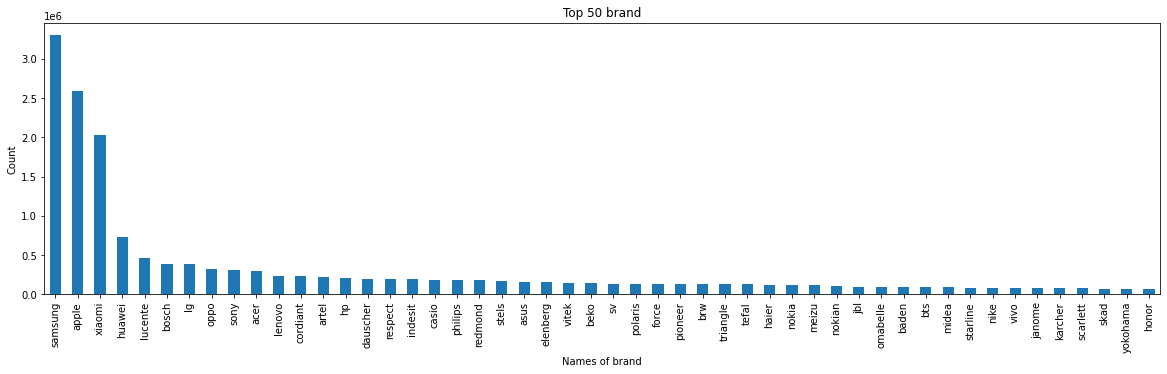

In [ ]:
non_purchase['brand'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Top 50 brand')
plt.xlabel('Names of brand')
plt.ylabel('Count')
plt.show();

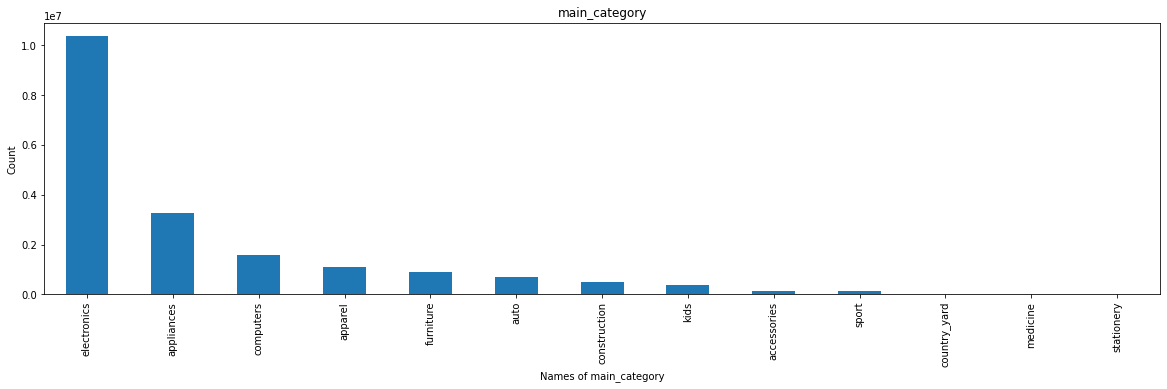

In [ ]:
non_purchase['main_category'].value_counts().plot.bar(figsize=(20,5))
plt.title('main_category')
plt.xlabel('Names of main_category')
plt.ylabel('Count')
plt.show();

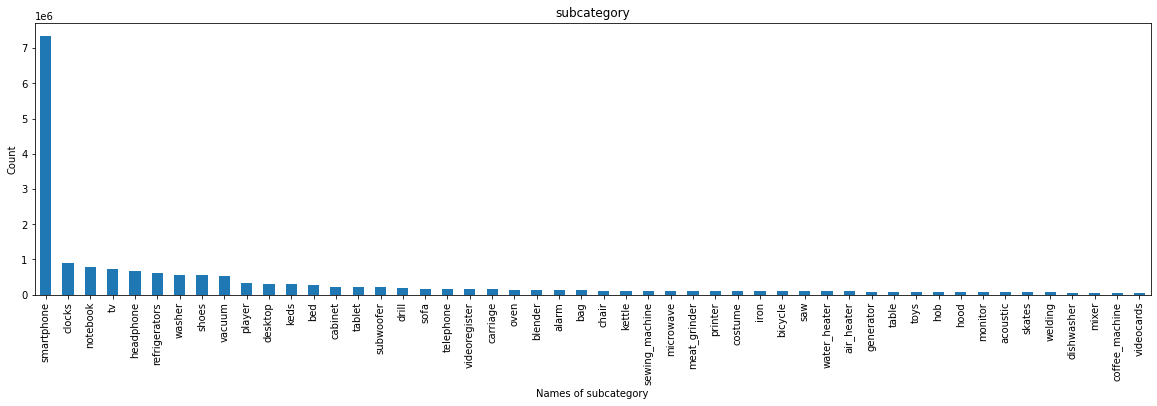

In [ ]:
non_purchase['subcategory'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('subcategory')
plt.xlabel('Names of subcategory')
plt.ylabel('Count')
plt.show();

### 매출액

In [ ]:
purchase

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,main_category,subcategory
0,2019-10-01 00:02:14,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564,electronics,smartphone
1,2019-10-01 00:04:37,purchase,1002532,2053013555631882655,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,electronics,smartphone
2,2019-10-01 00:06:02,purchase,5100816,2053013553375346967,NaN,xiaomi,29.51,514591159,0e5dfc4b-2a55-43e6-8c05-97e1f07fbb56,NaN,NaN
3,2019-10-01 00:07:07,purchase,13800054,2053013557418656265,furniture.bathroom.toilet,santeri,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f,furniture,toilet
4,2019-10-01 00:09:26,purchase,4804055,2053013554658804075,electronics.audio.headphone,apple,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553,electronics,headphone
...,...,...,...,...,...,...,...,...,...,...,...
704456,2019-10-31 23:53:53,purchase,1004767,2053013555631882655,electronics.smartphone,samsung,242.63,542774966,957dc70c-31d3-42b7-aef0-2d2827c35251,electronics,smartphone
704457,2019-10-31 23:55:21,purchase,47500017,2110937143172923797,construction.tools.light,puckator,20.59,514622109,5724116e-365b-4ac1-9d03-b8d66e1ccc7c,construction,light
704458,2019-10-31 23:56:03,purchase,1003306,2053013555631882655,electronics.smartphone,apple,577.89,512717356,f35ac37c-9573-4e30-b3d9-c09bb0b95a2b,electronics,smartphone
704459,2019-10-31 23:56:53,purchase,1004240,2053013555631882655,electronics.smartphone,apple,1054.60,533892594,3a5a3b01-2ab1-4a1d-a202-30d336e0057b,electronics,smartphone


In [ ]:
purchase['price'].sum()

224580792.34

In [ ]:
elec = purchase.loc[purchase['main_category'] == "electronics"]

In [ ]:
elec['price'].sum()

176464168.35999998

In [ ]:
(176464168.35999998 / 224580792.34) * 100 # 전체 매출에서 전자제품이 차지하는 비중

78.57491574472908

In [ ]:
appli = purchase.loc[purchase['main_category'] == "appliances"]

In [ ]:
appli['price'].sum()

13583121.92

In [ ]:
(13583121.92 / 224580792.34) * 100 # 전체 매출에서 가전제품이 차지하는 비중

6.048211772018366

### 제품의 유사도를 통한 추천 시스템
- electornics 를 구매한 고객 대상

In [ ]:
recommend = pd.read_csv("/content/drive/MyDrive/df.csv")

In [ ]:
recommend = recommend.drop(columns = 'Unnamed: 0')

In [ ]:
non_category = recommend[recommend['category_code'].isnull()].index
recommend.drop(non_category, inplace=True)

In [ ]:
recommend.shape

(28901528, 11)

In [ ]:
major = recommend.loc[(recommend['main_category'] == 'electronics')]
major.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,main_category,subcategory
4,2019-10-01 00:00:04,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,electronics,smartphone
9,2019-10-01 00:00:11,view,1004545,2053013555631882655,electronics.smartphone,huawei,566.01,537918940,406c46ed-90a4-4787-a43b-59a410c1a5fb,electronics,smartphone
11,2019-10-01 00:00:11,view,1005011,2053013555631882655,electronics.smartphone,samsung,900.64,530282093,50a293fb-5940-41b2-baf3-17af0e812101,electronics,smartphone
15,2019-10-01 00:00:18,view,1801995,2053013554415534427,electronics.video.tv,haier,193.03,537192226,e3151795-c355-4efa-acf6-e1fe1bebeee5,electronics,tv
18,2019-10-01 00:00:19,view,1005135,2053013555631882655,electronics.smartphone,apple,1747.79,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,electronics,smartphone


In [ ]:
major = major.reset_index(drop=True)

In [ ]:
major.drop(columns=['event_time', 'product_id','user_id','user_session','main_category','subcategory'], inplace=True)

In [ ]:
major.head()

,event_type,category_id,category_code,brand,price
0,view,2053013552326770905,appliances.environment.water_heater,aqua,33.20
1,view,2053013558920217191,computers.notebook,lenovo,251.74
2,view,2053013555631882655,electronics.smartphone,apple,1081.98
3,view,2053013561092866779,computers.desktop,pulser,908.62
4,view,2053013555631882655,electronics.smartphone,huawei,566.01


### baseline → view를 포함한 추천시스템 구현

In [ ]:
com_base = recommend.loc[(recommend['main_category'] == 'computers')]

In [ ]:
com_base = com_base.reset_index(drop=True)

In [ ]:
com_base.drop(columns=['event_time', 'product_id','category_id','user_id','main_category','subcategory'], inplace=True)

In [ ]:
com_base.head()

,event_type,category_code,brand,price,user_session
0,view,computers.notebook,lenovo,251.74,7c90fc70-0e80-4590-96f3-13c02c18c713
1,view,computers.desktop,pulser,908.62,0d0d91c2-c9c2-4e81-90a5-86594dec0db9
2,view,computers.notebook,hp,580.89,7c90fc70-0e80-4590-96f3-13c02c18c713
3,view,computers.desktop,pulser,921.49,0d0d91c2-c9c2-4e81-90a5-86594dec0db9
4,view,computers.peripherals.monitor,acer,514.79,3ea7c620-a8d7-45c5-9ced-2e9874e2f549


In [ ]:
tfidf = TfidfVectorizer()

# Fit 후 dtm을 만듭니다.(문서, 단어마다 tf-idf 값을 계산합니다)
dtm_com = tfidf.fit_transform(com_base['category_code'])

dtm_com = pd.DataFrame(dtm_com.todense(), columns=tfidf.get_feature_names())
dtm_com

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,camera,components,computers,cooler,cpu,desktop,ebooks,hdd,keyboard,memory,monitor,motherboard,mouse,notebook,peripherals,power_supply,printer,videocards
0,0.0,0.0,0.503803,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.863818,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.347276,0.0,0.0,0.937763,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.503803,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.863818,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.347276,0.0,0.0,0.937763,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.198039,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.809766,0.0,0.000000,0.000000,0.552322,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2321333,0.0,0.0,0.186389,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.833687,0.000000,0.519831,0.0,0.0,0.0
2321334,0.0,0.0,0.503803,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.863818,0.000000,0.0,0.0,0.0
2321335,0.0,0.0,0.503803,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.863818,0.000000,0.0,0.0,0.0
2321336,0.0,0.0,0.186389,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.833687,0.000000,0.519831,0.0,0.0,0.0


In [ ]:
nn = NearestNeighbors(n_neighbors=5)
nn.fit(dtm_com.values)

NearestNeighbors()

In [ ]:
com_base.loc[com_base['user_session'] == '629a0485-36c9-4a80-9f02-4a96382c3059']

,event_type,category_code,brand,price,user_session
170,view,computers.components.hdd,kingston,66.67,629a0485-36c9-4a80-9f02-4a96382c3059
206,view,computers.components.hdd,kingston,66.67,629a0485-36c9-4a80-9f02-4a96382c3059
259,purchase,computers.components.hdd,kingston,66.67,629a0485-36c9-4a80-9f02-4a96382c3059


In [ ]:
nn.kneighbors([dtm_com.iloc[259]])

(array([[0., 0., 0., 0., 0.]]),
 array([[2203883, 1602079, 1796557, 1433558,  374323]]))

In [ ]:
com_base.iloc[[259]]

,event_type,category_code,brand,price,user_session
259,purchase,computers.components.hdd,kingston,66.67,629a0485-36c9-4a80-9f02-4a96382c3059


In [ ]:
com_base.iloc[[2203883]]

,event_type,category_code,brand,price,user_session
2203883,view,computers.components.hdd,toshiba,44.19,a23796da-567a-4968-a9ab-d1cea5ef9ac5


In [ ]:
com_base.iloc[[1602079]]

,event_type,category_code,brand,price,user_session
1602079,view,computers.components.hdd,NaN,20.97,6f5aec3c-4587-4013-b8b3-0add97a8891a


In [ ]:
com_base.iloc[[1796557]]

,event_type,category_code,brand,price,user_session
1796557,view,computers.components.hdd,samsung,66.62,b8df4b03-93f4-4c10-b62e-95a5ec23d5f2


In [ ]:
com_base.iloc[[1433558]]

,event_type,category_code,brand,price,user_session
1433558,view,computers.components.hdd,kingston,40.13,b1f76a69-4427-4422-9fc6-62024e981a29


In [ ]:
com_base.iloc[[374323]]

,event_type,category_code,brand,price,user_session
374323,view,computers.components.hdd,toshiba,39.02,bddbb12f-1427-42d6-8e3e-103efed8e29b


### view 제외한 데이터셋으로 추천시스템

In [ ]:
without_view = major.loc[~(major['event_type'] == 'view')]

In [ ]:
without_view = without_view.reset_index(drop=True)

In [ ]:
without_view

,event_type,category_id,category_code,brand,price
0,purchase,2053013555631882655,electronics.smartphone,samsung,130.76
1,purchase,2053013555631882655,electronics.smartphone,apple,642.69
2,purchase,2053013554658804075,electronics.audio.headphone,apple,189.91
3,cart,2053013555631882655,electronics.smartphone,apple,515.67
4,purchase,2053013554658804075,electronics.audio.headphone,apple,161.98
...,...,...,...,...,...
1097181,cart,2053013555631882655,electronics.smartphone,apple,577.89
1097182,purchase,2053013555631882655,electronics.smartphone,apple,577.89
1097183,cart,2053013555631882655,electronics.smartphone,apple,1054.60
1097184,purchase,2053013555631882655,electronics.smartphone,apple,1054.60


In [ ]:
tfidf_without_view = TfidfVectorizer(stop_words= 'english', max_features=60)

# Fit 후 dtm을 만듭니다.(문서, 단어마다 tf-idf 값을 계산합니다)
dtm_tfidf_without_view = tfidf_without_view.fit_transform(without_view['category_code'])

dtm_tfidf_without_view = pd.DataFrame(dtm_tfidf_without_view.todense(), columns=tfidf_without_view.get_feature_names())
dtm_tfidf_without_view

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,acoustic,audio,camera,clocks,electronics,headphone,microphone,music_tools,photo,piano,projector,smartphone,subwoofer,tablet,telephone,tv,video
0,0.0,0.00000,0.0,0.0,0.636483,0.000000,0.0,0.0,0.0,0.0,0.0,0.771291,0.0,0.0,0.0,0.0,0.0
1,0.0,0.00000,0.0,0.0,0.636483,0.000000,0.0,0.0,0.0,0.0,0.0,0.771291,0.0,0.0,0.0,0.0,0.0
2,0.0,0.68591,0.0,0.0,0.194856,0.701112,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.00000,0.0,0.0,0.636483,0.000000,0.0,0.0,0.0,0.0,0.0,0.771291,0.0,0.0,0.0,0.0,0.0
4,0.0,0.68591,0.0,0.0,0.194856,0.701112,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097181,0.0,0.00000,0.0,0.0,0.636483,0.000000,0.0,0.0,0.0,0.0,0.0,0.771291,0.0,0.0,0.0,0.0,0.0
1097182,0.0,0.00000,0.0,0.0,0.636483,0.000000,0.0,0.0,0.0,0.0,0.0,0.771291,0.0,0.0,0.0,0.0,0.0
1097183,0.0,0.00000,0.0,0.0,0.636483,0.000000,0.0,0.0,0.0,0.0,0.0,0.771291,0.0,0.0,0.0,0.0,0.0
1097184,0.0,0.00000,0.0,0.0,0.636483,0.000000,0.0,0.0,0.0,0.0,0.0,0.771291,0.0,0.0,0.0,0.0,0.0


In [ ]:
cosine_similarity(dtm_tfidf_without_view, dtm_tfidf_without_view)

In [ ]:
nn_without_view = NearestNeighbors(n_neighbors=5)
nn_without_view.fit(dtm_tfidf_without_view.values)

NearestNeighbors()

In [ ]:
nn_without_view.kneighbors([dtm_tfidf_without_view.iloc[5]])

(array([[0., 0., 0., 0., 0.]]),
 array([[795669, 795670, 795667, 795664, 795671]]))

In [ ]:
without_view.iloc[[5]]

,event_type,category_id,category_code,brand,price
5,purchase,2053013555631882655,electronics.smartphone,apple,515.67


In [ ]:
without_view.iloc[[795669]]

,event_type,category_id,category_code,brand,price
795669,purchase,2053013555631882655,electronics.smartphone,apple,1088.57


In [ ]:
without_view.iloc[[795670]]

,event_type,category_id,category_code,brand,price
795670,purchase,2053013555631882655,electronics.smartphone,apple,469.49


In [ ]:
without_view.iloc[[795667]]

,event_type,category_id,category_code,brand,price
795667,cart,2053013555631882655,electronics.smartphone,apple,534.04


In [ ]:
without_view.iloc[[795664]]

,event_type,category_id,category_code,brand,price
795664,purchase,2053013555631882655,electronics.smartphone,apple,760.64


In [ ]:
without_view.iloc[[795671]]

,event_type,category_id,category_code,brand,price
795671,cart,2053013555631882655,electronics.smartphone,samsung,131.53


### 유저간 유사도를 통한 추천 시스템
- view 제외

In [ ]:
user = pd.read_csv("/content/drive/MyDrive/df.csv")

In [ ]:
user_com = user.loc[(user['main_category'] == 'computers')]

In [ ]:
user_com = user_com.drop(columns = 'Unnamed: 0')

In [ ]:
user_com = user_com.loc[~(user_com['event_type'] == 'view')]
user_com.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,main_category,subcategory
1886,2019-10-01 02:21:04,cart,1500021,2053013552955916539,computers.peripherals.printer,epson,116.73,513489079,63de1120-9d48-45d0-b024-500d1b95d71f,computers,printer
2035,2019-10-01 02:21:33,cart,1500021,2053013552955916539,computers.peripherals.printer,epson,116.73,513489079,63de1120-9d48-45d0-b024-500d1b95d71f,computers,printer
2285,2019-10-01 02:22:19,cart,1500021,2053013552955916539,computers.peripherals.printer,epson,116.73,513489079,63de1120-9d48-45d0-b024-500d1b95d71f,computers,printer
2302,2019-10-01 02:22:23,purchase,1307135,2053013558920217191,computers.notebook,hp,320.35,514805015,104dc3e4-d6ff-4f00-9031-c0468e75ed4c,computers,notebook
2346,2019-10-01 02:22:29,purchase,1500021,2053013552955916539,computers.peripherals.printer,epson,116.73,513489079,63de1120-9d48-45d0-b024-500d1b95d71f,computers,printer


In [ ]:
user_com = user_com.reset_index(drop=True)

In [ ]:
tfidf_com = TfidfVectorizer(stop_words='english', max_features=400)

# Fit 후 dtm을 만듭니다.(문서, 단어마다 tf-idf 값을 계산합니다)
dtm_user = tfidf_com.fit_transform(user_com['user_session'])

dtm_user = pd.DataFrame(dtm_user.todense(), columns=tfidf_com.get_feature_names_out())
dtm_user

,0177,09c135f5,0bb3fd21544e,122d,1f05,1feb4fadbe8a,25e8,3fcfb62ea75b,4002,4003,...,bd4e,bdb8,bdf9,d095d5410e6b,d352f427,da93ebd5,e0f7,e46a,f1d9d7ca9049,feaa
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55281,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55282,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
nn = NearestNeighbors(n_neighbors=5)
nn.fit(dtm_user.values)

NearestNeighbors()

In [ ]:
nn.kneighbors([dtm_user.iloc[912]])

(array([[0., 0., 0., 0., 0.]]), array([[35001, 35002, 34999, 34997, 35000]]))

In [ ]:
user_com.loc[user_com['user_session'] == '19acf33f-03bc-4c59-a7ee-5c4648b5a899']

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,main_category,subcategory
912,2019-10-01 18:34:39,purchase,1307366,2053013558920217191,computers.notebook,lenovo,248.63,552664696,19acf33f-03bc-4c59-a7ee-5c4648b5a899,computers,notebook


In [ ]:
user_com.loc[user_com['user_session'] == 'e7e29f7f-ef97-4cdc-a94e-21280c8e71fd']

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,main_category,subcategory
35002,2019-10-20 06:15:12,cart,17800123,2053013559868129947,computers.desktop,zeta,125.63,562124291,e7e29f7f-ef97-4cdc-a94e-21280c8e71fd,computers,desktop


In [ ]:
user_com.iloc[[912]]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,main_category,subcategory
912,2019-10-01 18:34:39,purchase,1307366,2053013558920217191,computers.notebook,lenovo,248.63,552664696,19acf33f-03bc-4c59-a7ee-5c4648b5a899,computers,notebook


In [ ]:
user_com.iloc[[35001]]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,main_category,subcategory
35001,2019-10-20 06:15:10,cart,1307076,2053013558920217191,computers.notebook,asus,694.97,516399346,2be0b8ca-e9e1-4476-a502-338bccf56e28,computers,notebook


In [ ]:
user_com.iloc[[35002]]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,main_category,subcategory
35002,2019-10-20 06:15:12,cart,17800123,2053013559868129947,computers.desktop,zeta,125.63,562124291,e7e29f7f-ef97-4cdc-a94e-21280c8e71fd,computers,desktop


In [ ]:
user_com.iloc[[34999]]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,main_category,subcategory
34999,2019-10-20 06:14:40,cart,6800653,2053013554222596431,computers.components.hdd,kingston,25.2,551711702,4633cbb7-bb70-4aa1-82d8-5204f91855cf,computers,hdd


In [ ]:
user_com.iloc[[34997]]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,main_category,subcategory
34997,2019-10-20 06:13:29,cart,6800658,2053013554222596431,computers.components.hdd,kingston,40.13,551711702,7d303c37-abf7-45be-be94-647958801a82,computers,hdd


In [ ]:
user_com.iloc[[35000]]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,main_category,subcategory
35000,2019-10-20 06:14:42,cart,1307341,2053013558920217191,computers.notebook,asus,592.01,517970831,4b931b67-5f43-4634-8372-8e7e05ea988f,computers,notebook


### Action plan → 충성고객에서 변심고객으로 변하는 이유
- 변심고객(segment3)의 조회와 구매기록 비교

In [ ]:
# segment3 고객의 view, purchase 기록 비교
seg3_customer = pd.read_csv("/content/drive/MyDrive/seg3_customer.csv")

In [ ]:
seg3_customer.head()

,v_user,v_time,event_type,v_product,v_brand,v_category,v_main,v_sub,v_price,p_user,p_time,event_type.1,p_product,p_brand,category_code,main_category,subcategory,p_price
0,547028884,2019-10-01 00:00:37,view,1701111,acer,computers.peripherals.monitor,computers,monitor,514.79,547028884,2019-10-01 03:42:52,purchase,1701302,samsung,computers.peripherals.monitor,computers,monitor,427.01
1,547028884,2019-10-01 00:00:37,view,1701111,acer,computers.peripherals.monitor,computers,monitor,514.79,547028884,2019-10-01 03:44:26,purchase,1701302,samsung,computers.peripherals.monitor,computers,monitor,427.01
2,547028884,2019-10-01 00:00:37,view,1701111,acer,computers.peripherals.monitor,computers,monitor,514.79,547028884,2019-10-01 03:47:15,purchase,1701302,samsung,computers.peripherals.monitor,computers,monitor,427.01
3,547028884,2019-10-01 00:00:37,view,1701111,acer,computers.peripherals.monitor,computers,monitor,514.79,547028884,2019-10-01 04:00:17,purchase,1701331,aoc,computers.peripherals.monitor,computers,monitor,385.85
4,547028884,2019-10-01 00:00:37,view,1701111,acer,computers.peripherals.monitor,computers,monitor,514.79,547028884,2019-10-01 04:07:31,purchase,1701303,samsung,computers.peripherals.monitor,computers,monitor,333.83


In [ ]:
seg3_customer['v_product'].value_counts()

1004856     56474
1004767     42074
1005115     32169
1004833     27039
1004870     25312
            ...  
10201522        1
18001193        1
4502518         1
28300064        1
12706531        1
Name: v_product, Length: 81380, dtype: int64

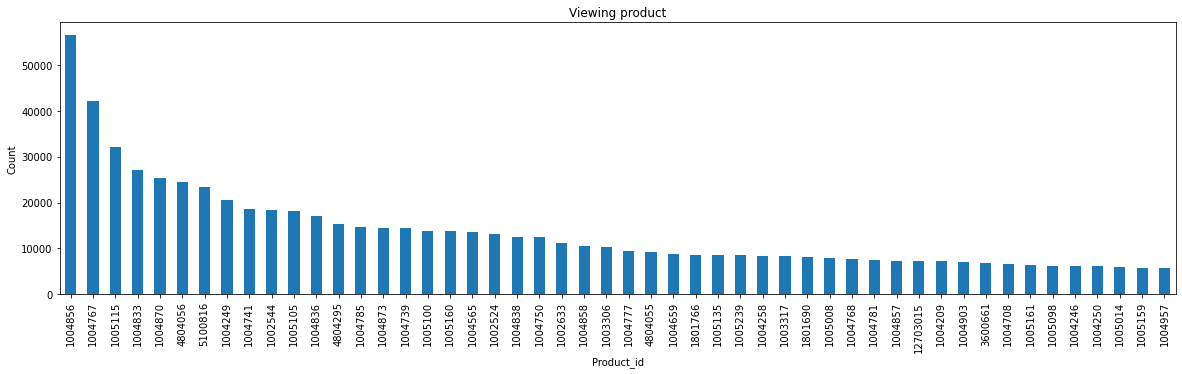

In [ ]:
seg3_customer['v_product'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Viewing product')
plt.xlabel('Product_id')
plt.ylabel('Count')
plt.show();

In [ ]:
seg3_customer['p_product'].value_counts()

1004856     74142
1004767     56043
5100816     54079
4804056     44393
1004870     41168
            ...  
17300588        1
30000079        1
5000056         1
7900760         1
29900018        1
Name: p_product, Length: 14959, dtype: int64

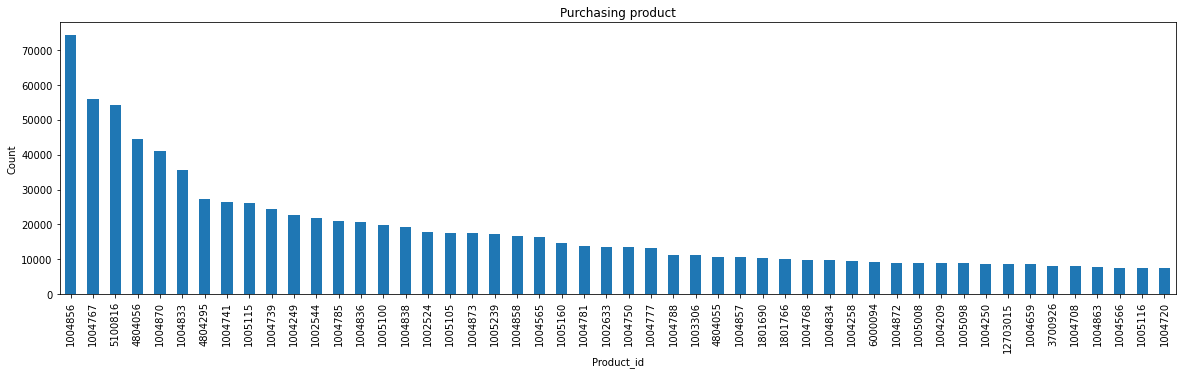

In [ ]:
seg3_customer['p_product'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Purchasing product')
plt.xlabel('Product_id')
plt.ylabel('Count')
plt.show();

- 조회 제품(v_product) 과 구매 제품(p_product) 의 전체 수량의 차이 존재

In [ ]:
seg3_customer['v_brand'].value_counts()

samsung      546333
apple        386228
xiaomi       336664
huawei       122744
lucente       65524
              ...  
yoobao            1
caiman            1
worth             1
megasaurs         1
cinemood          1
Name: v_brand, Length: 2867, dtype: int64

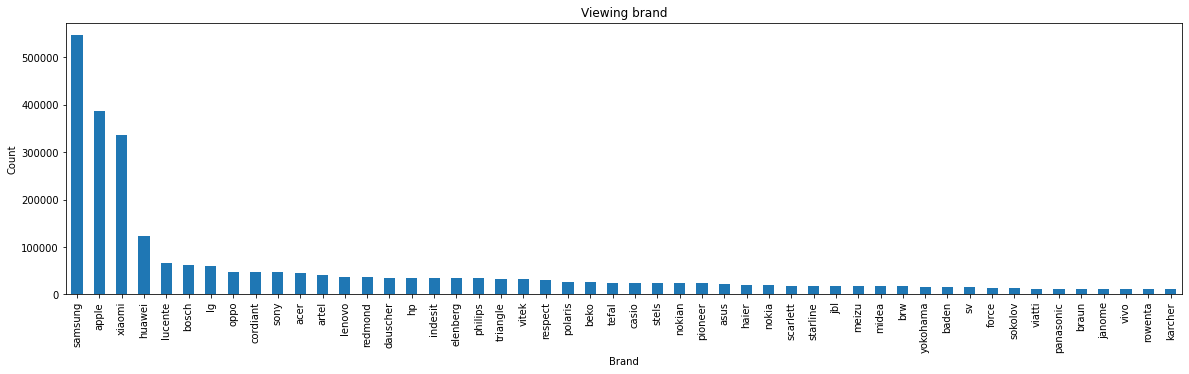

In [ ]:
seg3_customer['v_brand'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Viewing brand')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.show();

In [ ]:
seg3_customer['p_brand'].value_counts()

samsung                   639906
xiaomi                    424522
apple                     409776
huawei                    135162
cordiant                   69415
                           ...  
tesoro                         3
chigo                          2
maisonfranciskurkdjian         2
amos                           1
baltekstil                     1
Name: p_brand, Length: 1325, dtype: int64

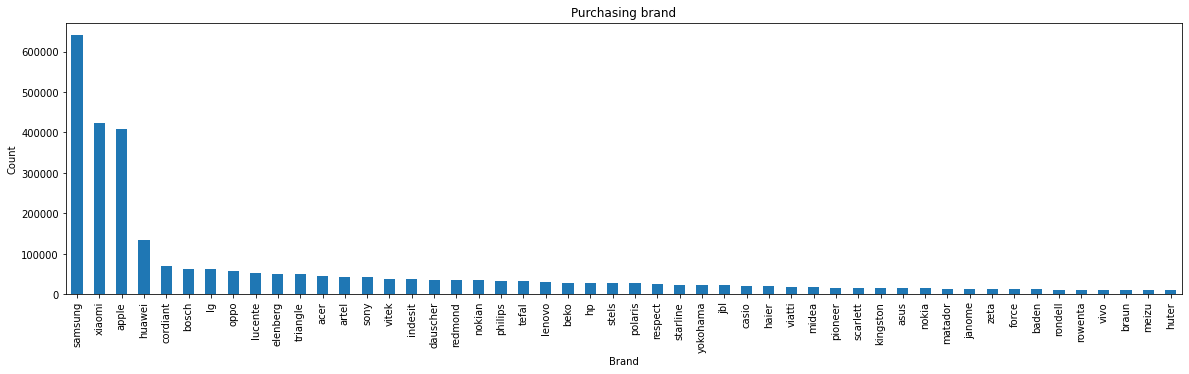

In [ ]:
seg3_customer['p_brand'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Purchasing brand')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.show();

In [ ]:
seg3_customer['v_category'].value_counts()

electronics.smartphone          1164179
electronics.audio.headphone      130492
electronics.clocks               127003
electronics.video.tv             120952
computers.notebook               114709
                                 ...   
construction.tools.soldering         84
apparel.skirt                        70
apparel.jacket                       26
country_yard.furniture.bench         23
auto.accessories.anti_freeze         20
Name: v_category, Length: 126, dtype: int64

In [ ]:
seg3_customer['category_code'].value_counts()

electronics.smartphone         1308560
electronics.audio.headphone     161663
electronics.video.tv            120455
appliances.kitchen.washer       109332
electronics.clocks              105940
                                ...   
apparel.trousers                    67
auto.accessories.winch              28
furniture.universal.light           21
sport.ski                           20
apparel.skirt                       10
Name: category_code, Length: 117, dtype: int64

In [ ]:
seg3_customer['v_main'].value_counts()

electronics     1671240
appliances       599189
computers        262528
apparel          154240
auto             130016
furniture        126635
construction      90708
kids              53571
accessories       35063
sport             14181
medicine           1809
stationery         1166
country_yard        959
Name: v_main, dtype: int64

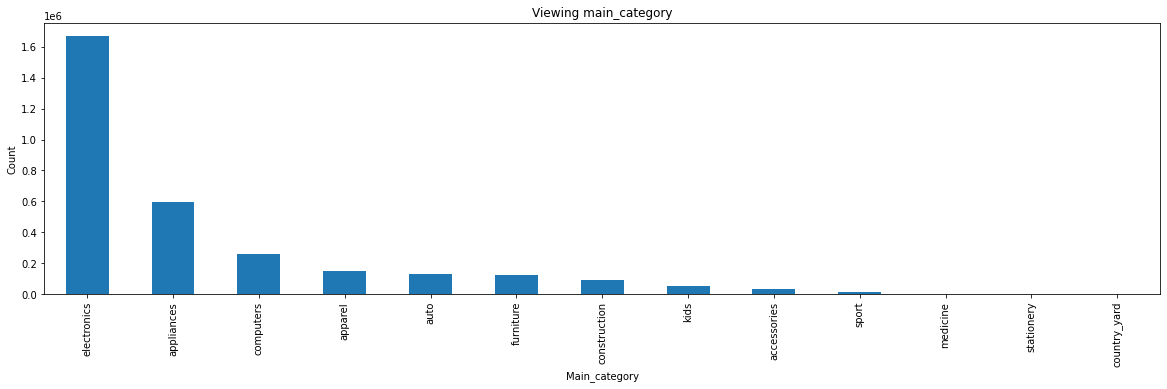

In [ ]:
seg3_customer['v_main'].value_counts().plot.bar(figsize=(20,5))
plt.title('Viewing main_category')
plt.xlabel('Main_category')
plt.ylabel('Count')
plt.show();

In [ ]:
seg3_customer['main_category'].value_counts()

electronics     1810493
appliances       634853
computers        242575
auto             108059
apparel           96961
construction      88514
furniture         85979
kids              46032
accessories       24321
sport              9010
medicine           3196
stationery         2632
country_yard        845
Name: main_category, dtype: int64

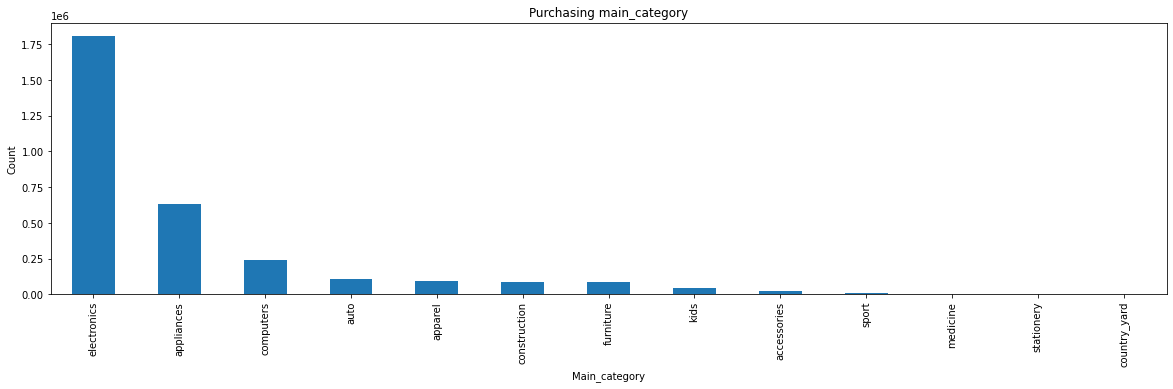

In [ ]:
seg3_customer['main_category'].value_counts().plot.bar(figsize=(20,5))
plt.title('Purchasing main_category')
plt.xlabel('Main_category')
plt.ylabel('Count')
plt.show();

In [ ]:
seg3_customer['v_sub'].value_counts()

smartphone     1164179
headphone       130492
clocks          127003
tv              120952
notebook        114709
                ...   
soldering           84
skirt               70
jacket              26
bench               23
anti_freeze         20
Name: v_sub, Length: 124, dtype: int64

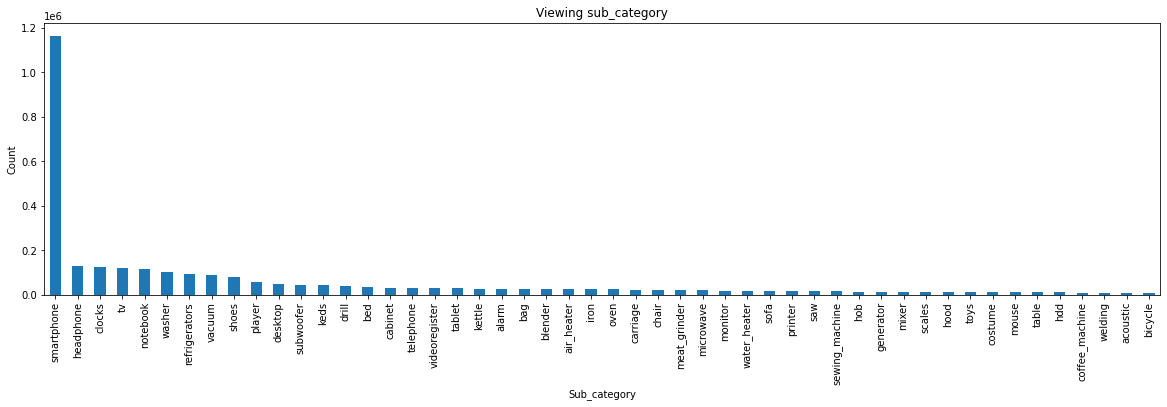

In [ ]:
seg3_customer['v_sub'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Viewing sub_category')
plt.xlabel('Sub_category')
plt.ylabel('Count')
plt.show();

In [ ]:
seg3_customer['subcategory'].value_counts()

smartphone    1308560
headphone      161663
tv             120455
washer         109332
clocks         105940
               ...   
camera             76
trousers           67
winch              28
ski                20
skirt              10
Name: subcategory, Length: 115, dtype: int64

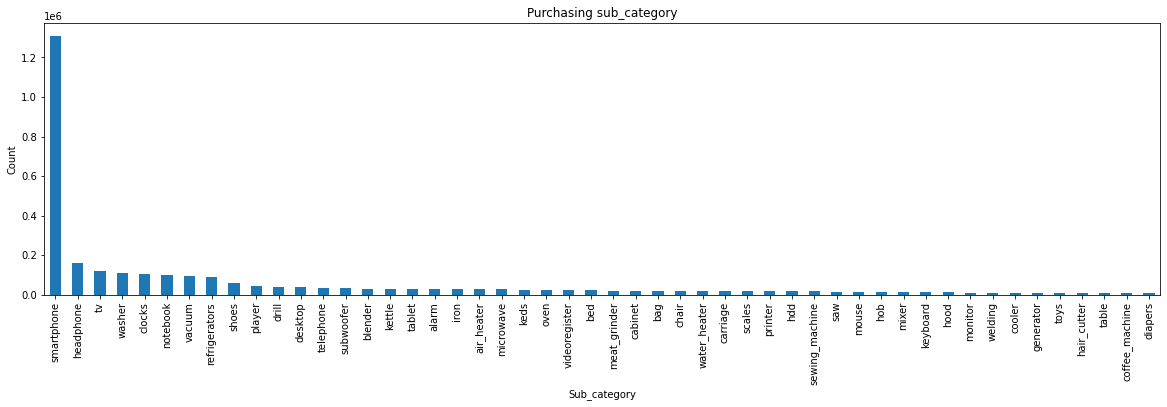

In [ ]:
seg3_customer['subcategory'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Purchasing sub_category')
plt.xlabel('Sub_category')
plt.ylabel('Count')
plt.show();

- 선호 카테고리에는 조회와 구매의 차이는 크게 없음

In [ ]:
view_mean = seg3_customer['v_price'].mean()
view_mean

258.6865774196666

In [ ]:
view_med = seg3_customer['v_price'].median()
view_med

142.86

In [ ]:
purchase_mean = seg3_customer['p_price'].mean()
purchase_mean

227.05771559649355

In [ ]:
purchase_med = seg3_customer['p_price'].median()
purchase_med

135.01

In [ ]:
data = [["view", 258.686577, 142.86],
        ['purchase', 227.057716, 135.01]]

In [ ]:
view_purchase = pd.DataFrame(data, columns=['data','mean','median'])

In [ ]:
view_purchase

,data,mean,median
0,view,258.686577,142.86
1,purchase,227.057716,135.01


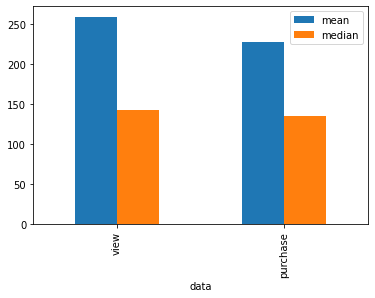

In [ ]:
view_purchase.plot.bar(x='data', y=['mean','median'])
plt.show();

- 가격 측면에서 조회와 구매의 차이가 존재
- 조회한 상품의 평균, 중앙값이 구매 상품의 것보다 높은 것을 확인

#### 다른 고객군에서도 조회제품이 구매제품보다 가격이 높게 나타날까?

In [ ]:
without_viewing = pd.read_csv("/content/drive/MyDrive/RFM_without_view.csv")
viewing = pd.read_csv("/content/drive/MyDrive/RFM_viewing.csv")

In [ ]:
without_viewing.columns

Index(['field1', 'event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session',
       'main_category', 'subcategory', 'user_id.1', 'Recency', 'Frequency',
       'Monetary', 'Recency_score', 'Frequency_score', 'Monetary_score',
       'RFM_seg', 'RFM_score', 'RFM_label'],
      dtype='object')

In [ ]:
without_viewing.drop(columns=['field1', 'product_id', 'category_id', 'user_session', 'user_id.1', 'Recency', 'Frequency',
       'Monetary', 'Recency_score', 'Frequency_score', 'Monetary_score', 'RFM_seg', 'RFM_score'], inplace=True)

In [ ]:
without_viewing.head()

,event_time,event_type,category_code,brand,price,user_id,main_category,subcategory,RFM_label
0,2019-10-01 00:02:14,purchase,electronics.smartphone,samsung,130.76,543272936,electronics,smartphone,segment1
1,2019-10-01 00:04:37,purchase,electronics.smartphone,apple,642.69,551377651,electronics,smartphone,segment1
2,2019-10-01 00:06:02,purchase,NaN,xiaomi,29.51,514591159,NaN,NaN,segment5
3,2019-10-01 00:07:07,purchase,furniture.bathroom.toilet,santeri,54.42,555332717,furniture,toilet,segment2
4,2019-10-01 00:09:26,purchase,electronics.audio.headphone,apple,189.91,524601178,electronics,headphone,segment5


In [ ]:
viewing.drop(columns=['user_id.1', 'Recency', 'Frequency','Monetary', 'Recency_score', 'Frequency_score', 'Monetary_score', 'RFM_seg', 'RFM_score'], inplace=True)

In [ ]:
viewing.head()

,event_time,category_code,brand,price,user_id,main_category,subcategory,RFM_label
0,2019-10-01 00:00:00,NaN,shiseido,35.79,541312140,NaN,NaN,segment5
1,2019-10-01 00:00:05,computers.desktop,pulser,908.62,512742880,computers,desktop,segment4
2,2019-10-01 00:00:15,NaN,shiseido,35.79,541312140,NaN,NaN,segment5
3,2019-10-01 00:00:22,computers.desktop,pulser,921.49,512742880,computers,desktop,segment4
4,2019-10-01 00:00:23,electronics.smartphone,xiaomi,197.55,519530528,electronics,smartphone,segment5


In [ ]:
seg1_view = viewing.loc[viewing['RFM_label'] == 'segment1']
seg2_view = viewing.loc[viewing['RFM_label'] == 'segment2']
seg4_view = viewing.loc[viewing['RFM_label'] == 'segment4']
seg5_view = viewing.loc[viewing['RFM_label'] == 'segment5']

In [ ]:
seg1_purchase = without_viewing.loc[(without_viewing['RFM_label'] == 'segment1') & (without_viewing['event_type'] == 'purchase')]
seg2_purchase = without_viewing.loc[(without_viewing['RFM_label'] == 'segment2') & (without_viewing['event_type'] == 'purchase')]
seg4_purchase = without_viewing.loc[(without_viewing['RFM_label'] == 'segment4') & (without_viewing['event_type'] == 'purchase')]
seg5_purchase = without_viewing.loc[(without_viewing['RFM_label'] == 'segment5') & (without_viewing['event_type'] == 'purchase')]

In [ ]:
seg2_purchase.head()

,event_time,event_type,category_code,brand,price,user_id,main_category,subcategory,RFM_label
3,2019-10-01 00:07:07,purchase,furniture.bathroom.toilet,santeri,54.42,555332717,furniture,toilet,segment2
30,2019-10-01 02:21:53,purchase,NaN,tefal,38.59,513070042,NaN,NaN,segment2
51,2019-10-01 02:23:59,purchase,electronics.smartphone,samsung,174.76,524102669,electronics,smartphone,segment2
63,2019-10-01 02:25:30,purchase,electronics.smartphone,apple,739.81,552056470,electronics,smartphone,segment2
69,2019-10-01 02:26:23,purchase,electronics.smartphone,samsung,628.78,516025438,electronics,smartphone,segment2


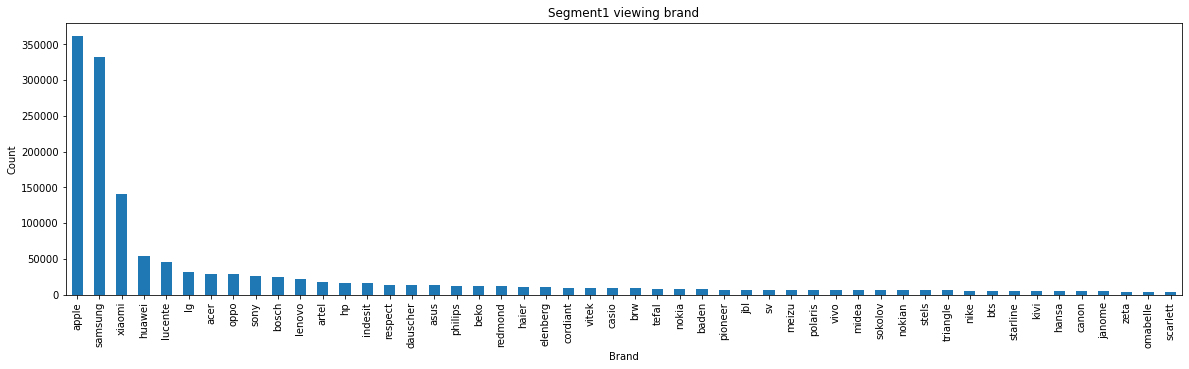

In [ ]:
seg1_view['brand'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Segment1 viewing brand')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.show();

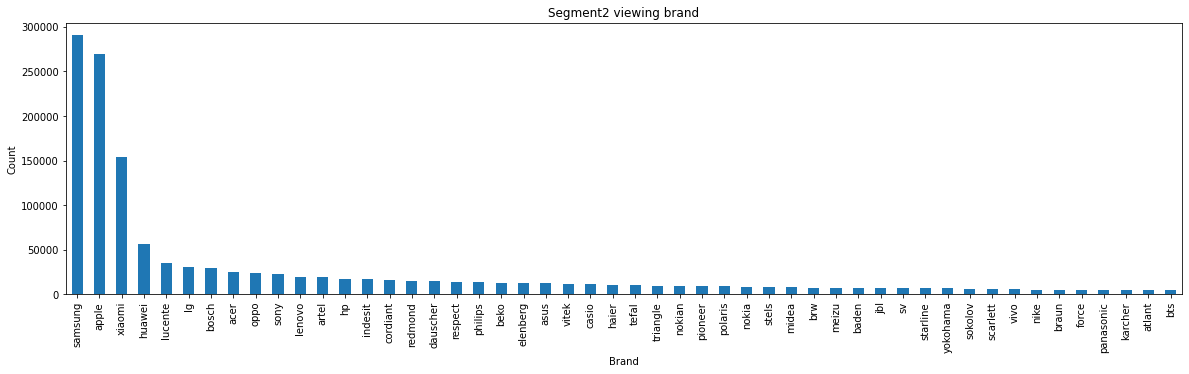

In [ ]:
seg2_view['brand'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Segment2 viewing brand')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.show();

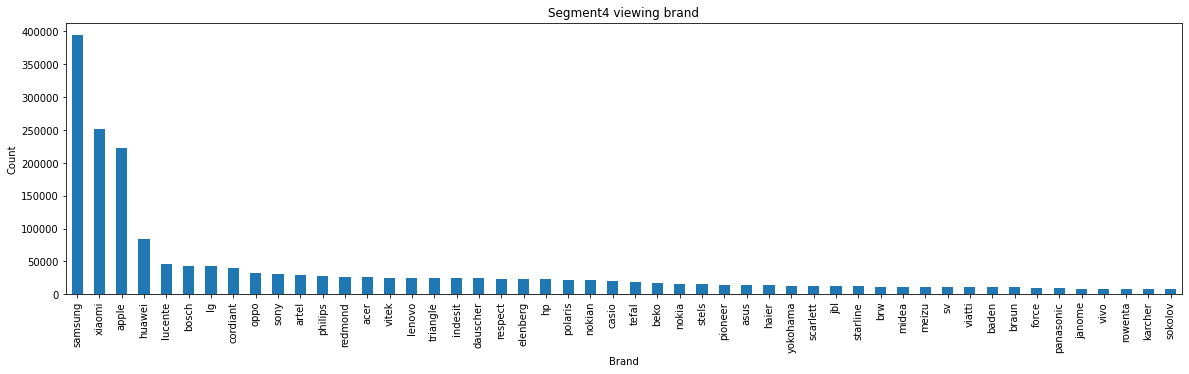

In [ ]:
seg4_view['brand'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Segment4 viewing brand')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.show();

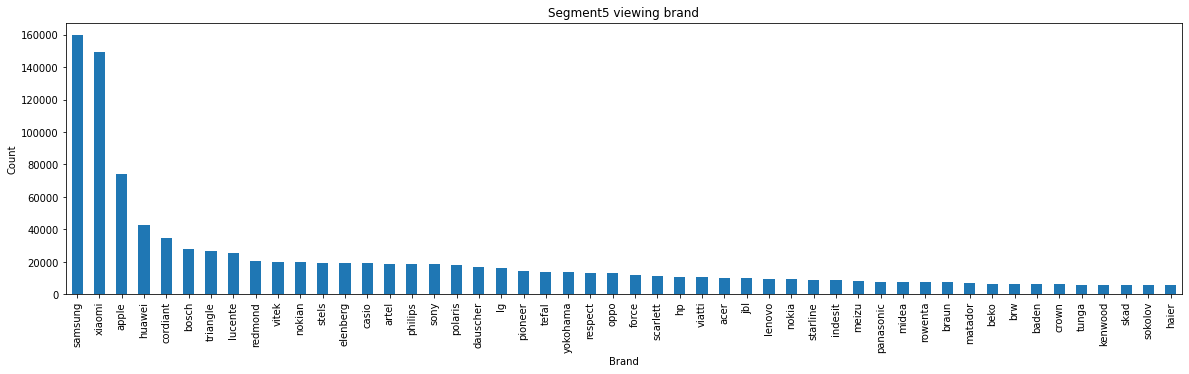

In [ ]:
seg5_view['brand'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Segment5 viewing brand')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.show();

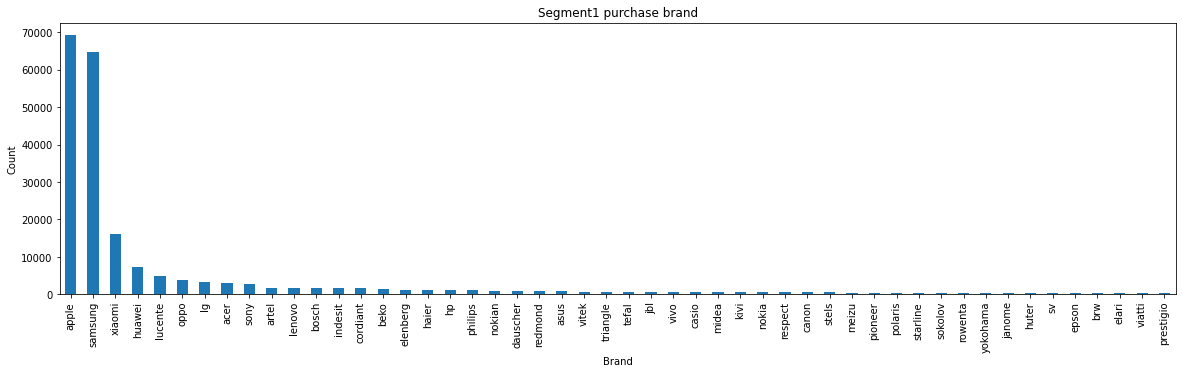

In [ ]:
seg1_purchase['brand'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Segment1 purchase brand')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.show();

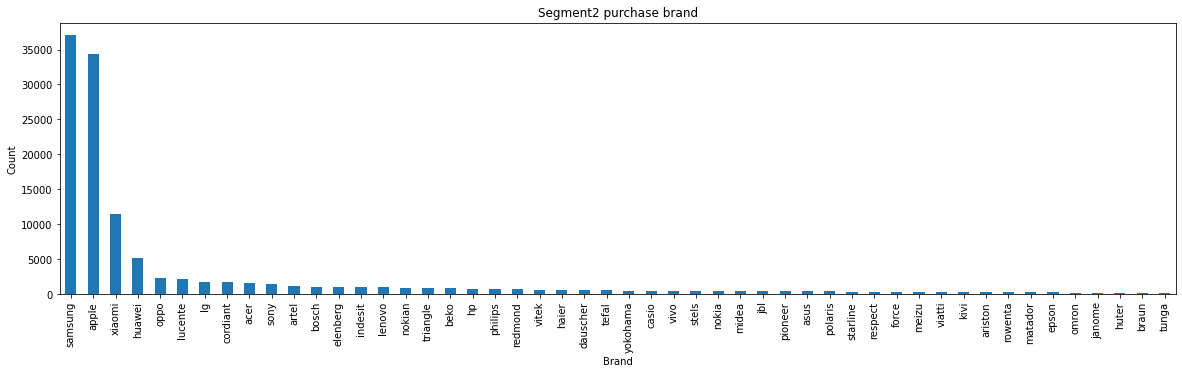

In [ ]:
seg2_purchase['brand'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Segment2 purchase brand')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.show();

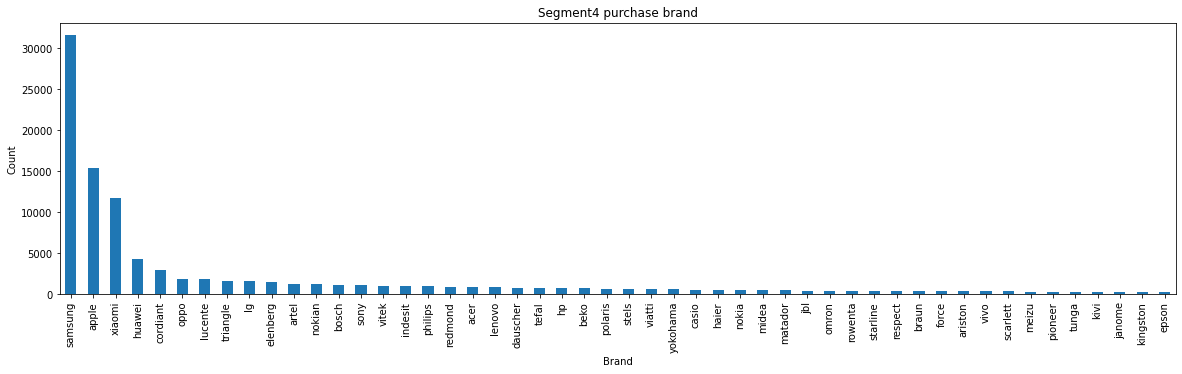

In [ ]:
seg4_purchase['brand'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Segment4 purchase brand')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.show();

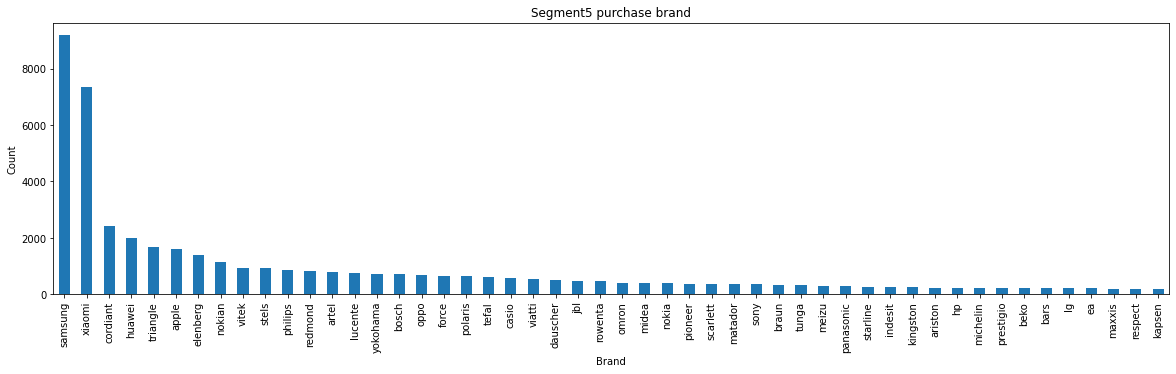

In [ ]:
seg5_purchase['brand'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Segment5 purchase brand')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.show();

- segment1 view : 애플 → 삼성 → 샤오미 → 화웨이
- segment1 purchase : 애플 → 삼성 → 샤오미 →화웨이
---
- segment2 view : 삼성 → 애플 →샤오미 →화웨이
- segment2 purchase : 삼성 → 애플 → 샤오미 → 화웨이
---
- segment4 view : 삼성 → 샤오미 → 애플 → 화웨이
- segment4 purchase : 삼성 → 애플 → 샤오미 → 화웨이
---
- segment5 view : 삼성 → 샤오미 → 애플 → 화웨이
- segment5 purchase : 삼성 → 샤오미 → 코디언트 → 화웨이

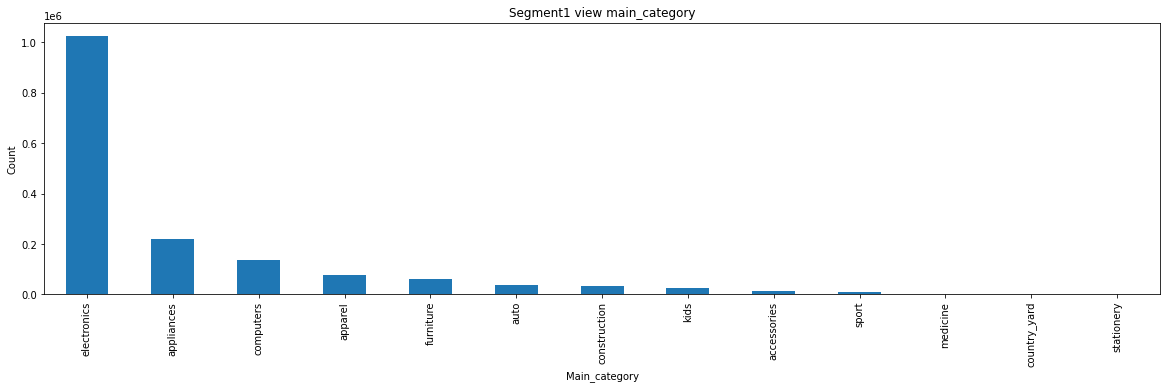

In [ ]:
seg1_view['main_category'].value_counts().plot.bar(figsize=(20,5))
plt.title('Segment1 view main_category')
plt.xlabel('Main_category')
plt.ylabel('Count')
plt.show();

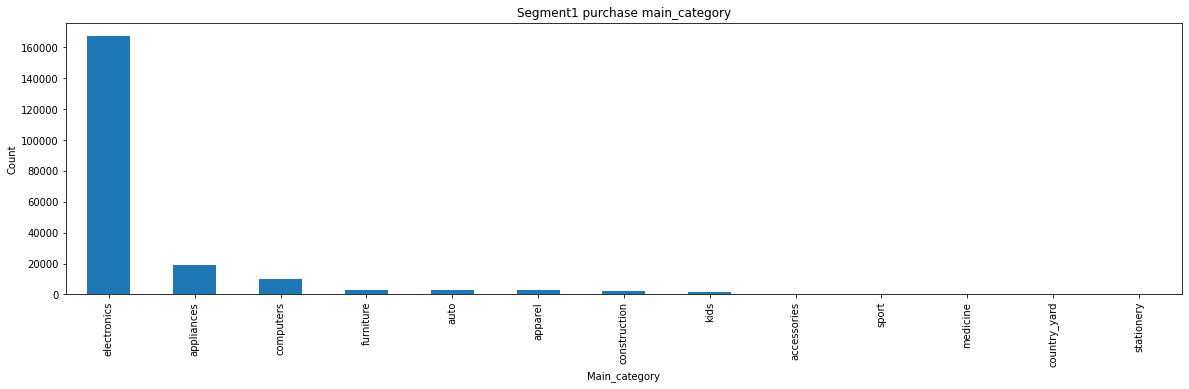

In [ ]:
seg1_purchase['main_category'].value_counts().plot.bar(figsize=(20,5))
plt.title('Segment1 purchase main_category')
plt.xlabel('Main_category')
plt.ylabel('Count')
plt.show();

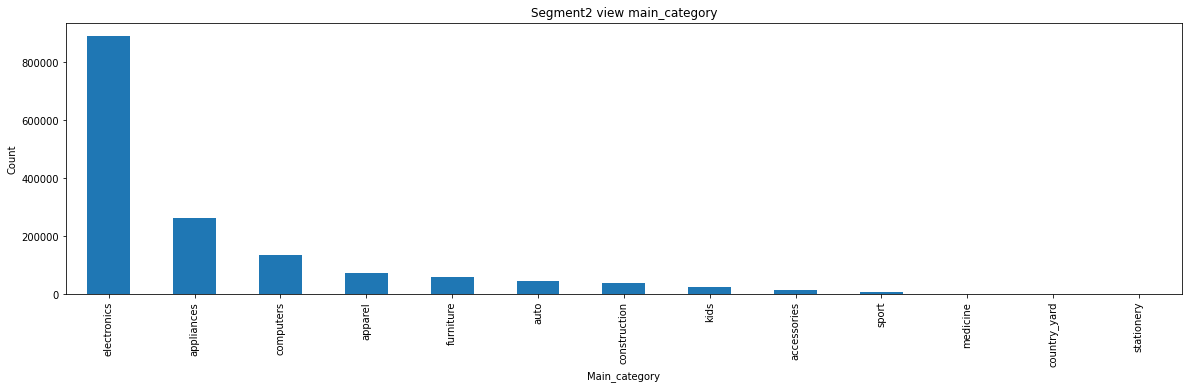

In [ ]:
seg2_view['main_category'].value_counts().plot.bar(figsize=(20,5))
plt.title('Segment2 view main_category')
plt.xlabel('Main_category')
plt.ylabel('Count')
plt.show();

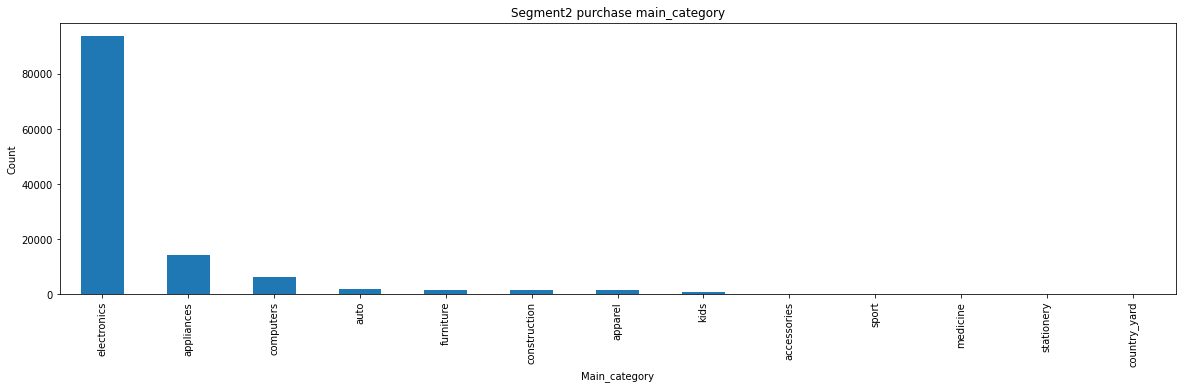

In [ ]:
seg2_purchase['main_category'].value_counts().plot.bar(figsize=(20,5))
plt.title('Segment2 purchase main_category')
plt.xlabel('Main_category')
plt.ylabel('Count')
plt.show();

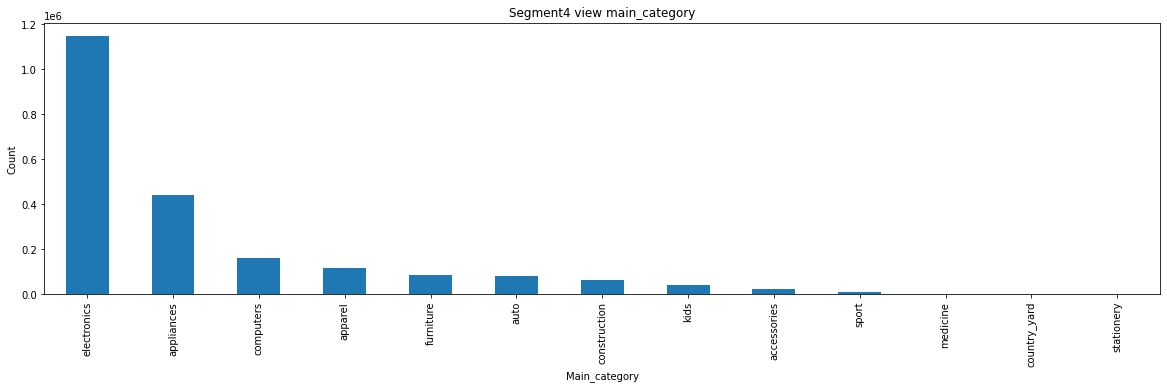

In [ ]:
seg4_view['main_category'].value_counts().plot.bar(figsize=(20,5))
plt.title('Segment4 view main_category')
plt.xlabel('Main_category')
plt.ylabel('Count')
plt.show();

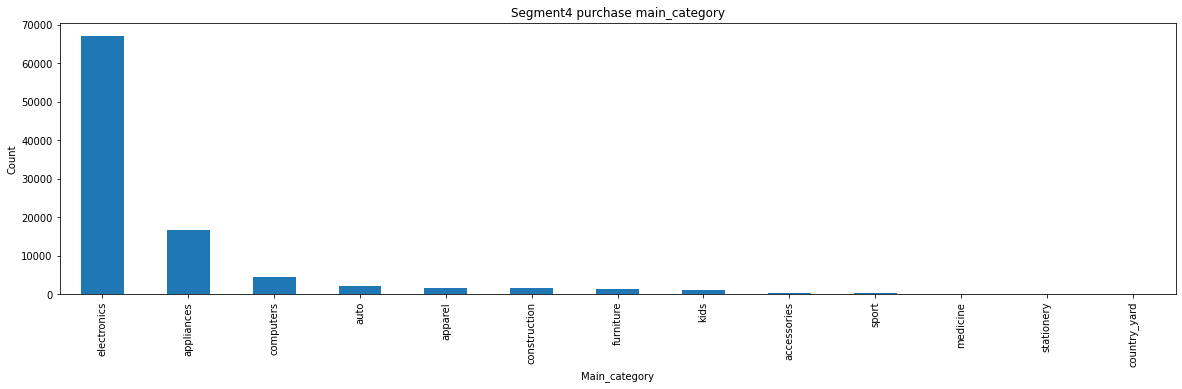

In [ ]:
seg4_purchase['main_category'].value_counts().plot.bar(figsize=(20,5))
plt.title('Segment4 purchase main_category')
plt.xlabel('Main_category')
plt.ylabel('Count')
plt.show();

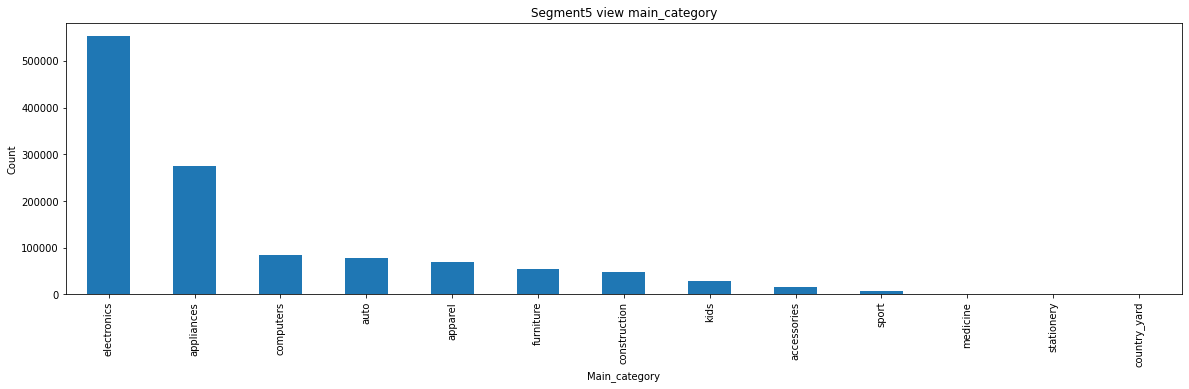

In [ ]:
seg5_view['main_category'].value_counts().plot.bar(figsize=(20,5))
plt.title('Segment5 view main_category')
plt.xlabel('Main_category')
plt.ylabel('Count')
plt.show();

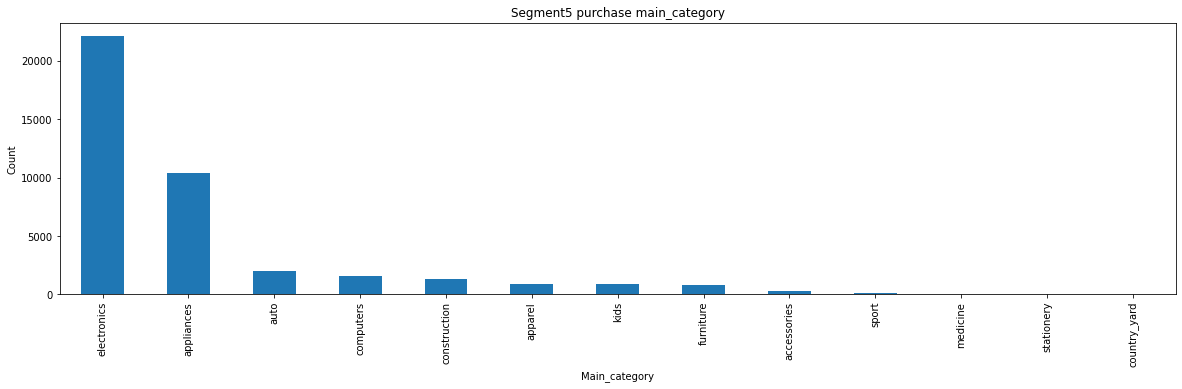

In [ ]:
seg5_purchase['main_category'].value_counts().plot.bar(figsize=(20,5))
plt.title('Segment5 purchase main_category')
plt.xlabel('Main_category')
plt.ylabel('Count')
plt.show();

- segment5 를 제외한 다른 고객군에서는 모두 동일하게 electronics → appliances → computers 가 상위에 위치
- segment5의 경우 조회제품군의 대분류에서는 다른 고객군과 일치하지만 구매제품군에서는 electronics → appliancs → auto → computers 가 상위에 위치 

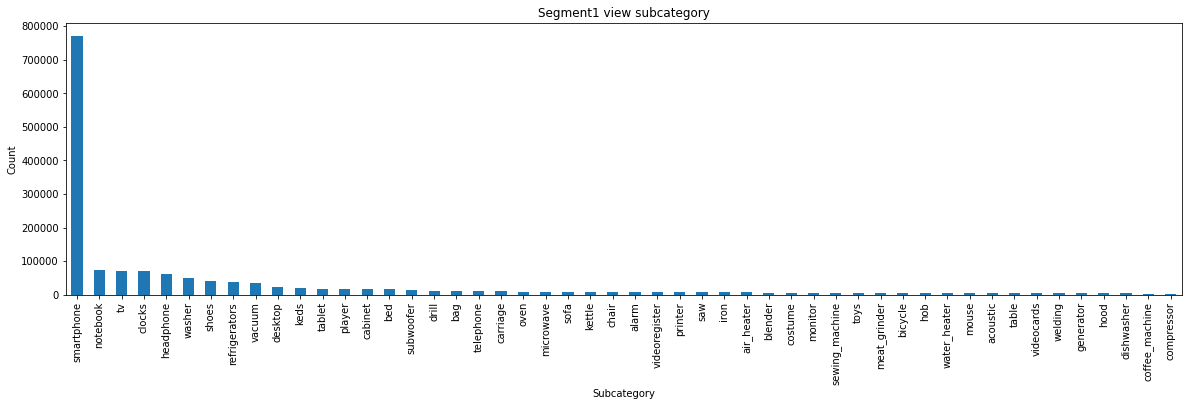

In [ ]:
seg1_view['subcategory'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Segment1 view subcategory')
plt.xlabel('Subcategory')
plt.ylabel('Count')
plt.show();

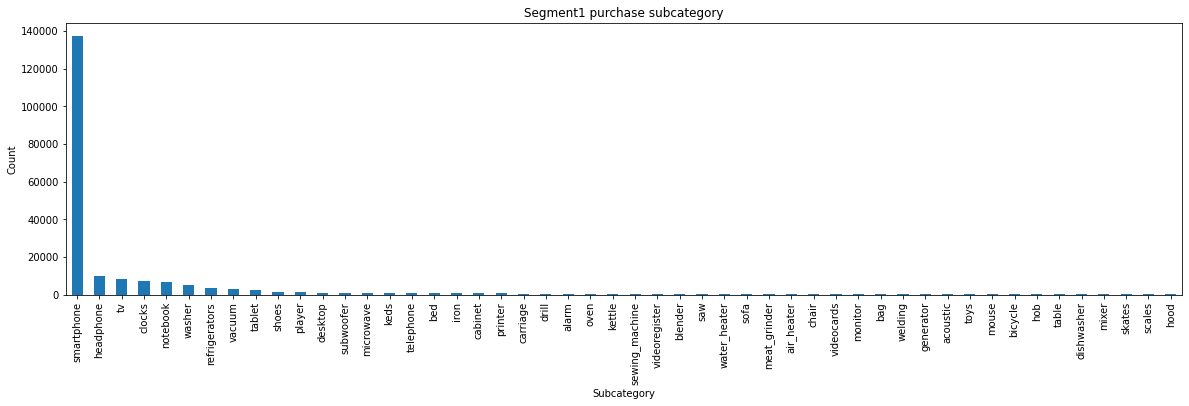

In [ ]:
seg1_purchase['subcategory'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Segment1 purchase subcategory')
plt.xlabel('Subcategory')
plt.ylabel('Count')
plt.show();

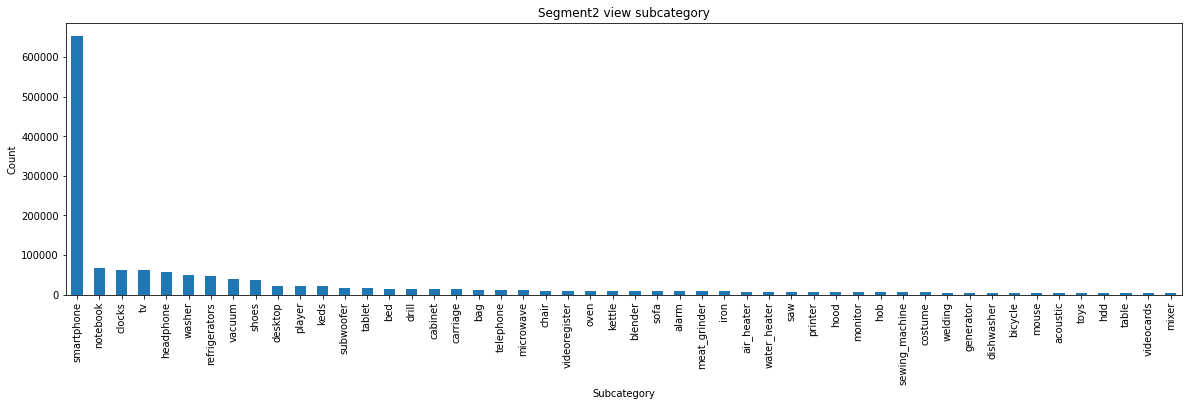

In [ ]:
seg2_view['subcategory'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Segment2 view subcategory')
plt.xlabel('Subcategory')
plt.ylabel('Count')
plt.show();

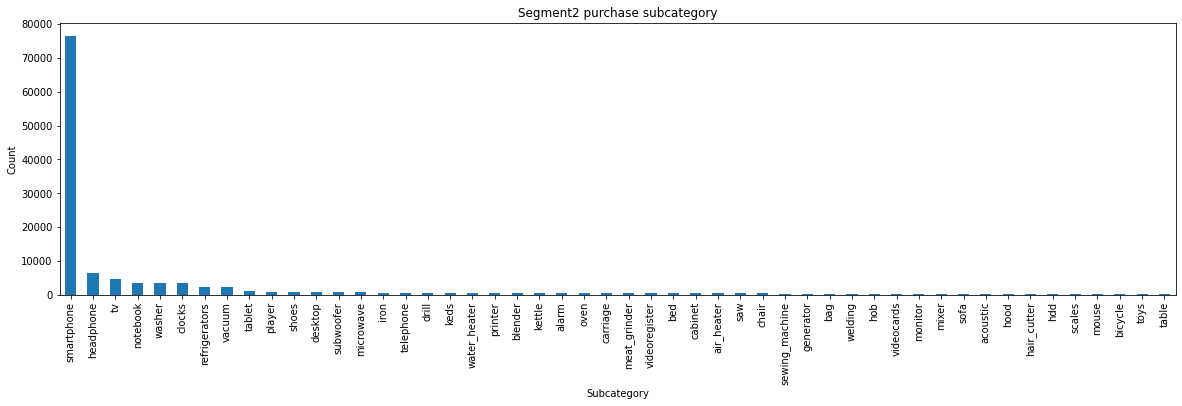

In [ ]:
seg2_purchase['subcategory'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Segment2 purchase subcategory')
plt.xlabel('Subcategory')
plt.ylabel('Count')
plt.show();

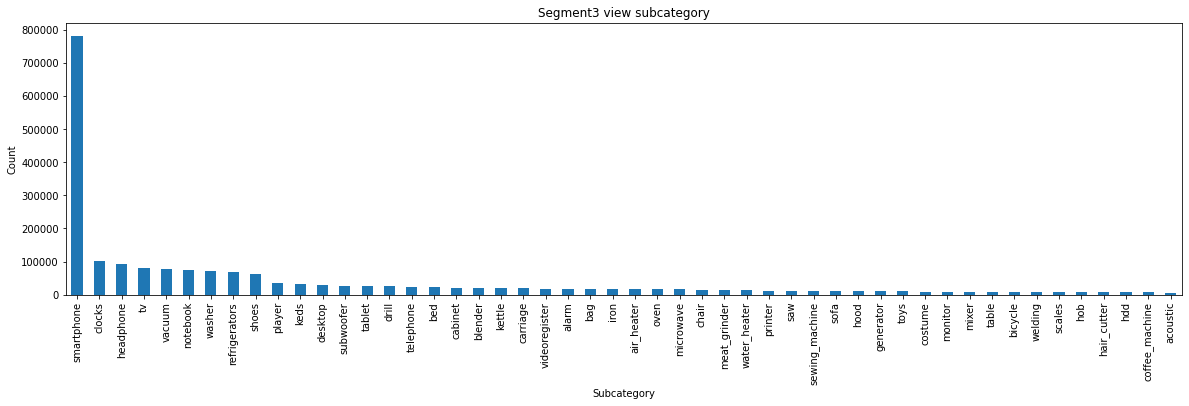

In [ ]:
seg4_view['subcategory'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Segment3 view subcategory')
plt.xlabel('Subcategory')
plt.ylabel('Count')
plt.show();

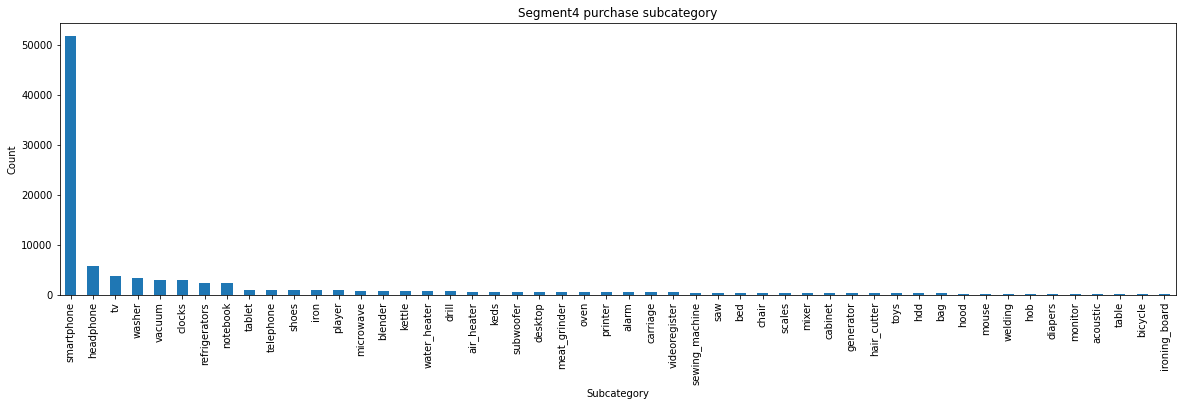

In [ ]:
seg4_purchase['subcategory'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Segment4 purchase subcategory')
plt.xlabel('Subcategory')
plt.ylabel('Count')
plt.show();

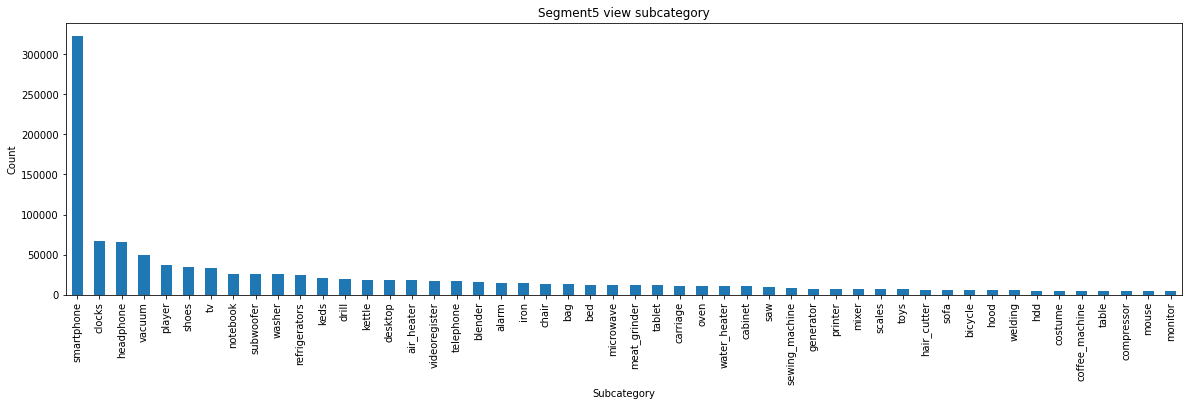

In [ ]:
seg5_view['subcategory'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Segment5 view subcategory')
plt.xlabel('Subcategory')
plt.ylabel('Count')
plt.show();

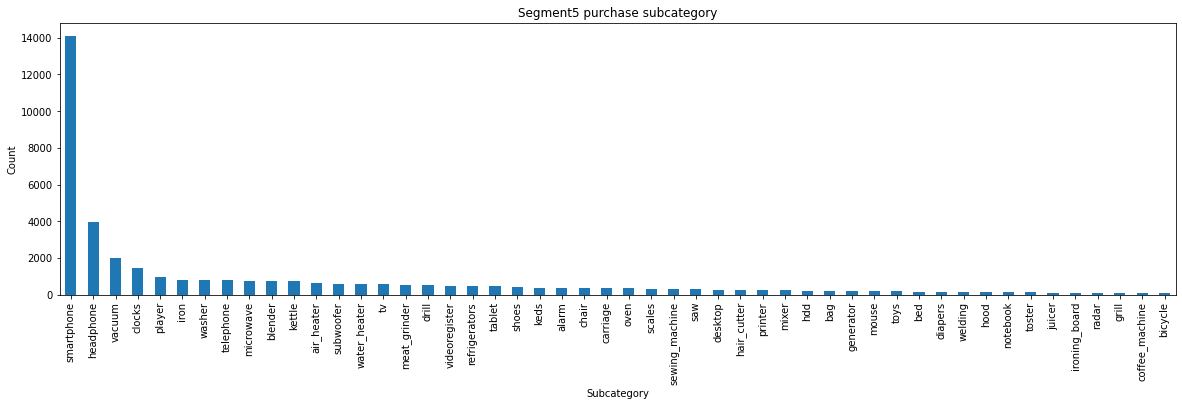

In [ ]:
seg5_purchase['subcategory'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Segment5 purchase subcategory')
plt.xlabel('Subcategory')
plt.ylabel('Count')
plt.show();

- segment1 view : 스마트폰 → 노트북 → 티비 → 시계 → 헤드폰
- segment1 purchase : 스마트폰 → 헤드폰 → 티비 → 시계 → 노트북
---
- segment2 view : 스마트폰 → 노트북 → 시계 → 티비 → 헤드폰
- segment2 purchase : 스마트폰 → 헤드폰 → 티비 → 노트북 → 워셔(washer)
---
- segment4 view : 스마트폰 → 시계 → 헤드폰 → 티비 → 청소기
- segment4 purchase : 스마트폰 → 헤드폰 → 티비 → washer → 청소기
---
- segment5 view : 스마트폰 → 시계 → 헤드폰 → 청소기 → 게임기(player)
- segment5 purchase : 스마트폰 → 헤드폰 → 청소기 → 시계 → 게임기

In [ ]:
seg1view_mean = seg1_view['price'].mean()
seg1view_mean

358.44700506950517

In [ ]:
seg2view_mean = seg2_view['price'].mean()
seg2view_mean

315.89784125935466

In [ ]:
seg4view_mean = seg4_view['price'].mean()
seg4view_mean

240.47232501402218

In [ ]:
seg5view_mean = seg5_view['price'].mean()
seg5view_mean

178.13393649679026

In [ ]:
seg1purchase_mean = seg1_purchase['price'].mean()
seg1purchase_mean

406.6623959699554

In [ ]:
seg2purchase_mean = seg2_purchase['price'].mean()
seg2purchase_mean

354.62159225014045

In [ ]:
seg4purchase_mean = seg4_purchase['price'].mean()
seg4purchase_mean

230.48887969987354

In [ ]:
seg5purchase_mean = seg5_purchase['price'].mean()
seg5purchase_mean

88.11725415284657

In [ ]:
seg1view_med = seg1_view['price'].median()
seg1view_med

216.21

In [ ]:
seg2view_med = seg2_view['price'].median()
seg2view_med

177.1

In [ ]:
seg4view_med = seg4_view['price'].median()
seg4view_med

137.69

In [ ]:
seg5view_med = seg5_view['price'].median()
seg5view_med

89.84

In [ ]:
seg1purchase_med = seg1_purchase['price'].median()
seg1purchase_med

250.86

In [ ]:
seg2purchase_med = seg2_purchase['price'].median()
seg2purchase_med

204.12

In [ ]:
seg4purchase_med = seg4_purchase['price'].median()
seg4purchase_med

153.84

In [ ]:
seg5purchase_med = seg5_purchase['price'].median()
seg5purchase_med

70.53

In [ ]:
data = [['segment', 'segment1', 'segment2','segment4','segment5'],
        ["view_mean", 358.44700506950517, 315.89784125935466, 240.47232501402218, 178.13393649679026],
        ['purchase_mean', 406.6623959699554, 354.62159225014045, 230.48887969987354, 88.11725415284657],
        ["view_med", 216.21, 177.1, 137.69, 89.84],
        ["purchase_med", 250.86, 204.12, 153.84, 70.53]]

In [ ]:
data = [['segment1',358.44700506950517, 406.6623959699554, 216.21, 250.86], 
        ['segment2', 315.89784125935466, 354.62159225014045, 177.1, 204.12],
        ['segment4', 240.47232501402218, 230.48887969987354, 137.69, 153.84],
        ['segment5', 178.13393649679026, 88.11725415284657, 89.84, 70.53]]

In [ ]:
segment = pd.DataFrame(data, columns=['segment','view_mean','purchase_mean','view_med','purchase_med'])

In [ ]:
segment

,segment,view_mean,purchase_mean,view_med,purchase_med
0,segment1,358.447005,406.662396,216.21,250.86
1,segment2,315.897841,354.621592,177.10,204.12
2,segment4,240.472325,230.488880,137.69,153.84
3,segment5,178.133936,88.117254,89.84,70.53


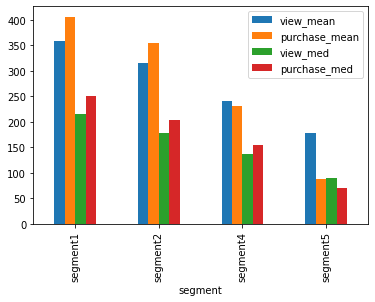

In [ ]:
segment.plot.bar(x='segment', y=['view_mean','purchase_mean','view_med','purchase_med'])
plt.show();